## Run with single command

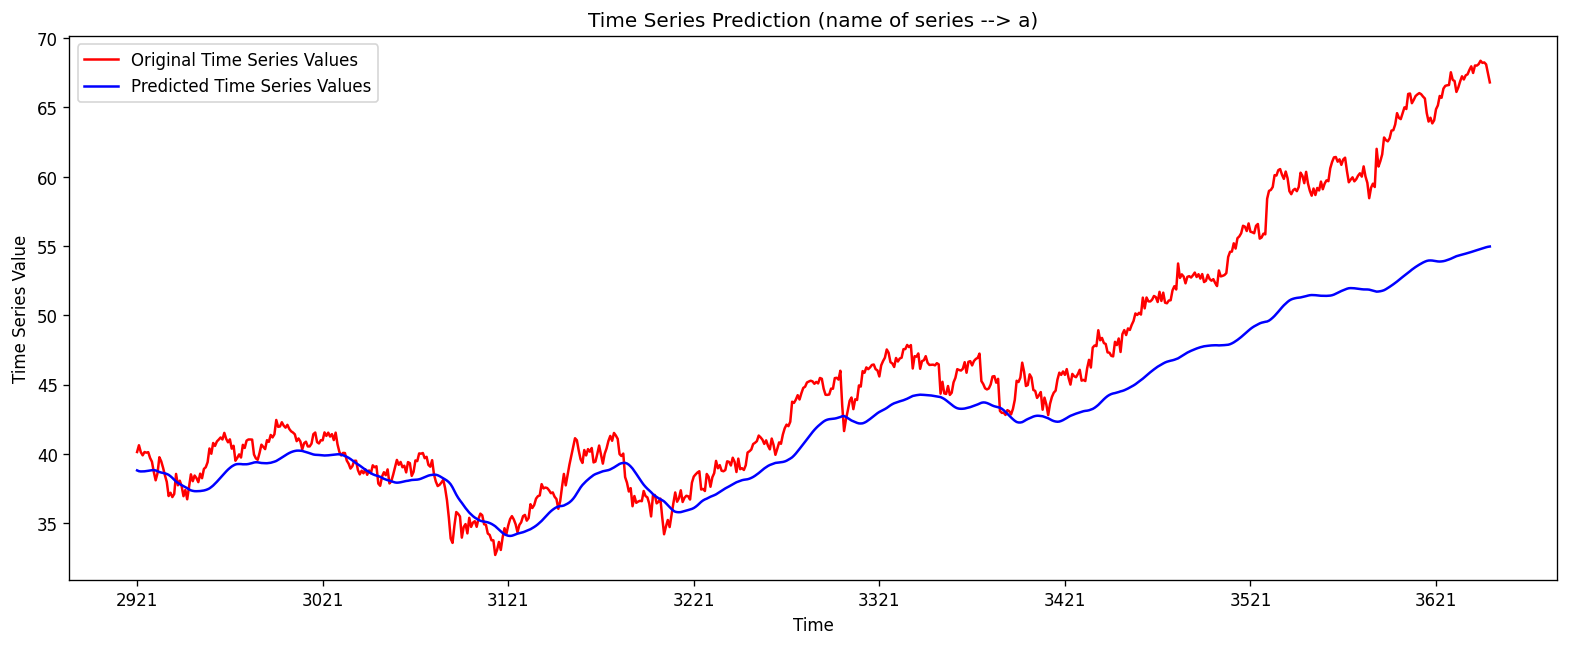

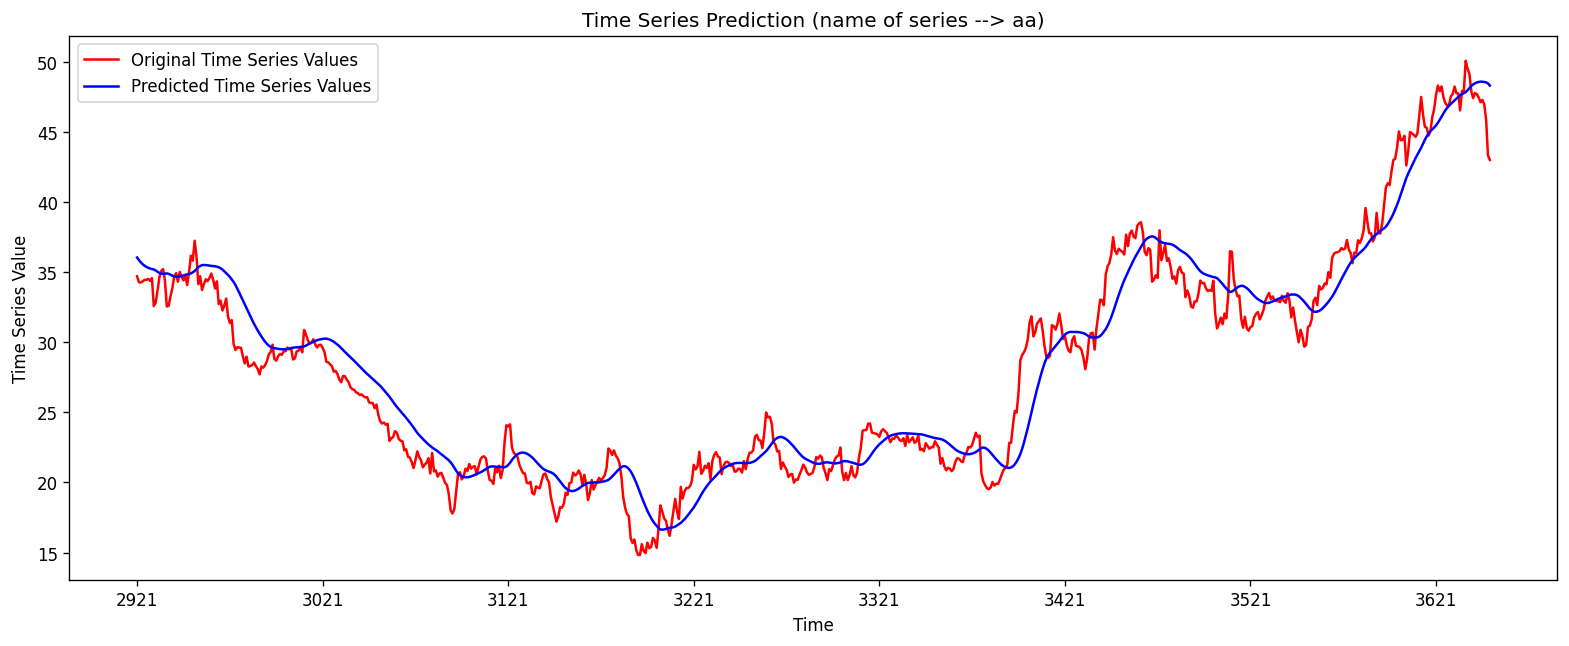

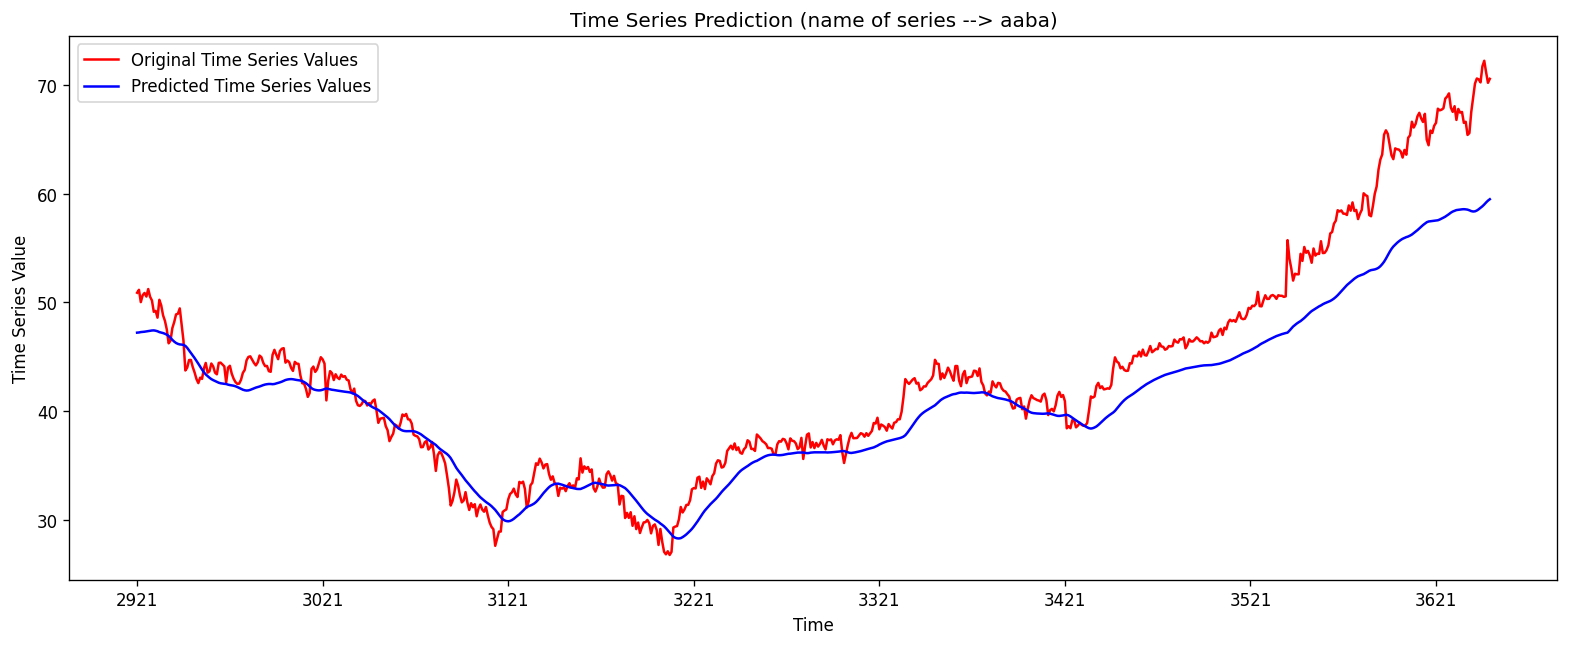

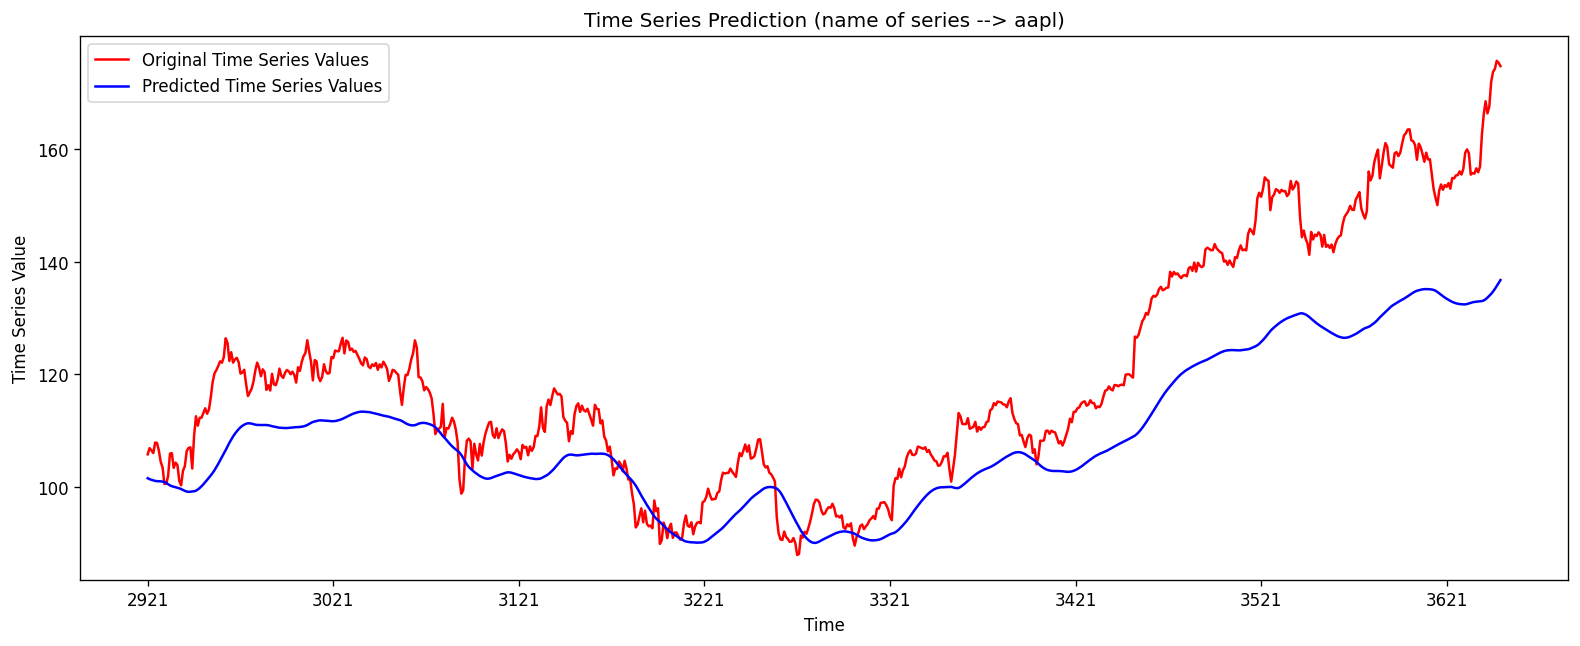

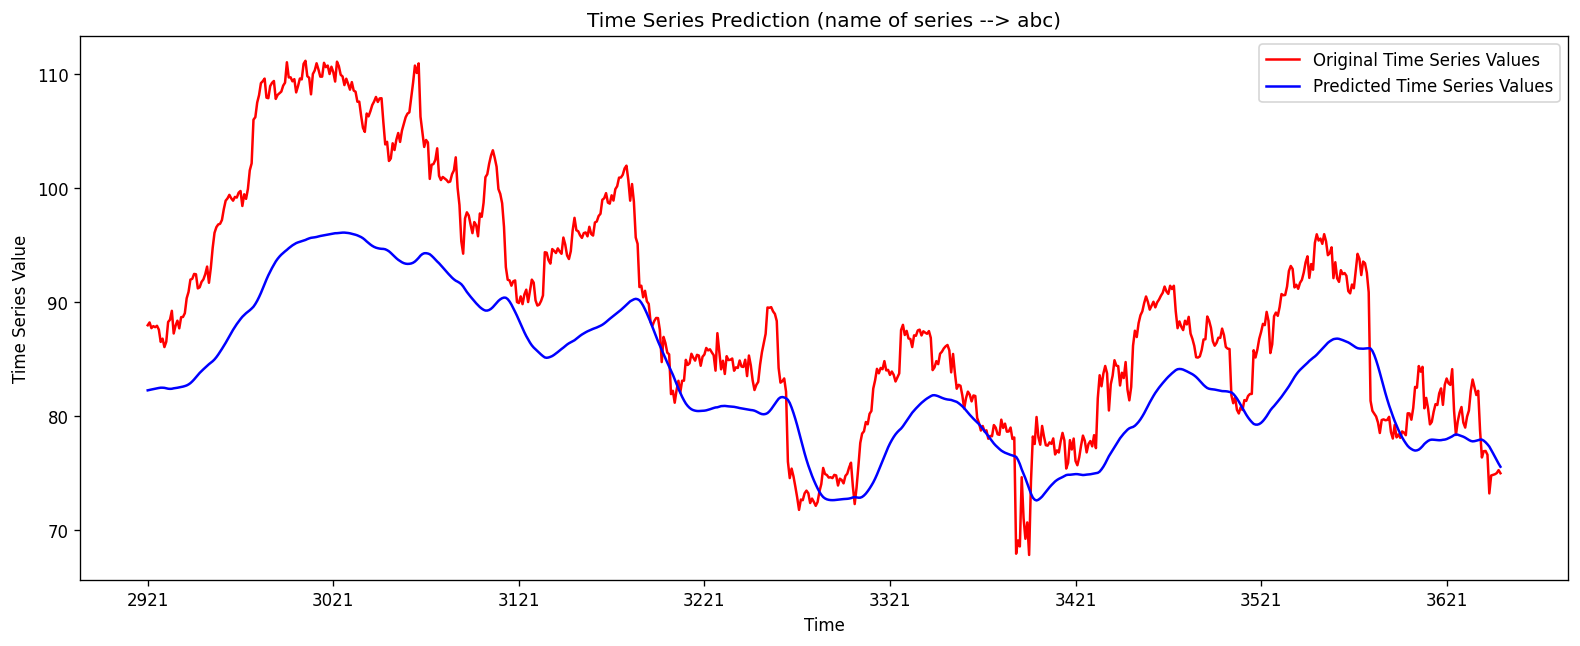

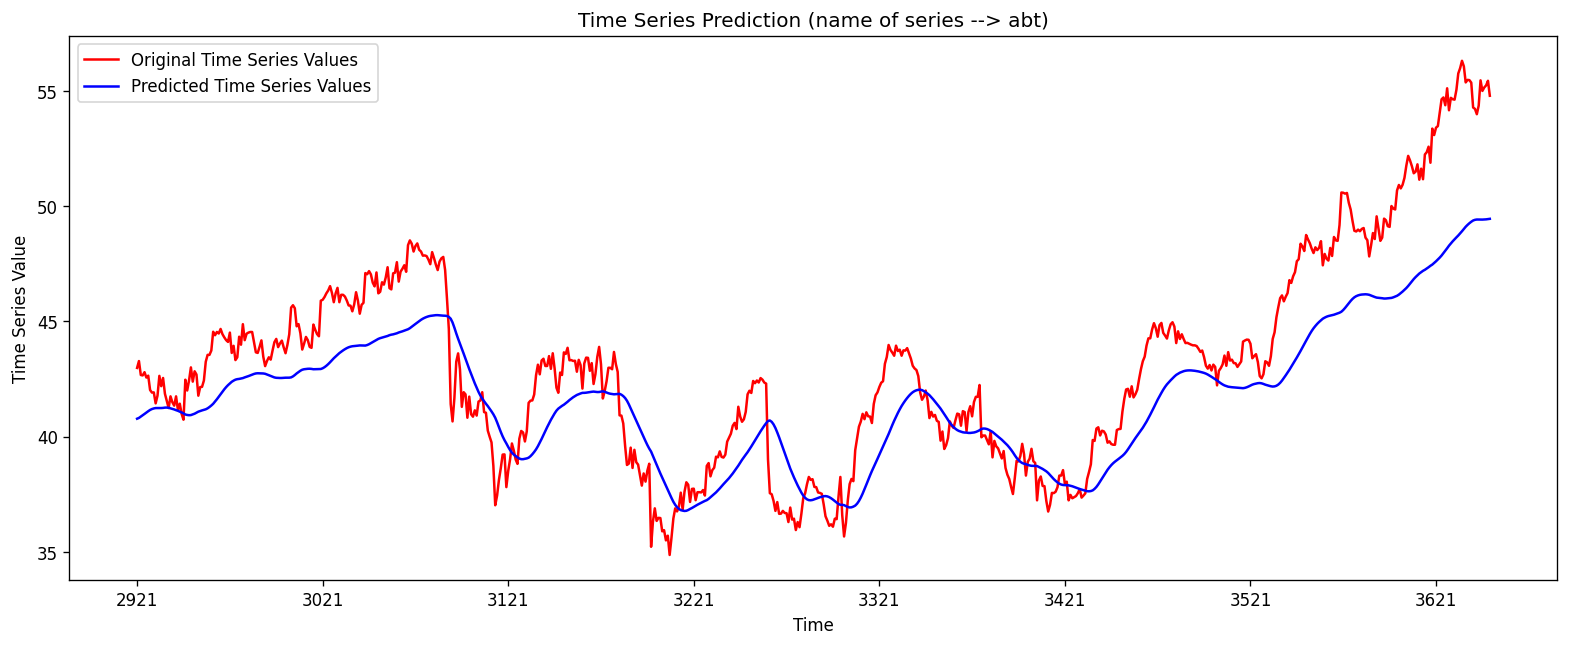

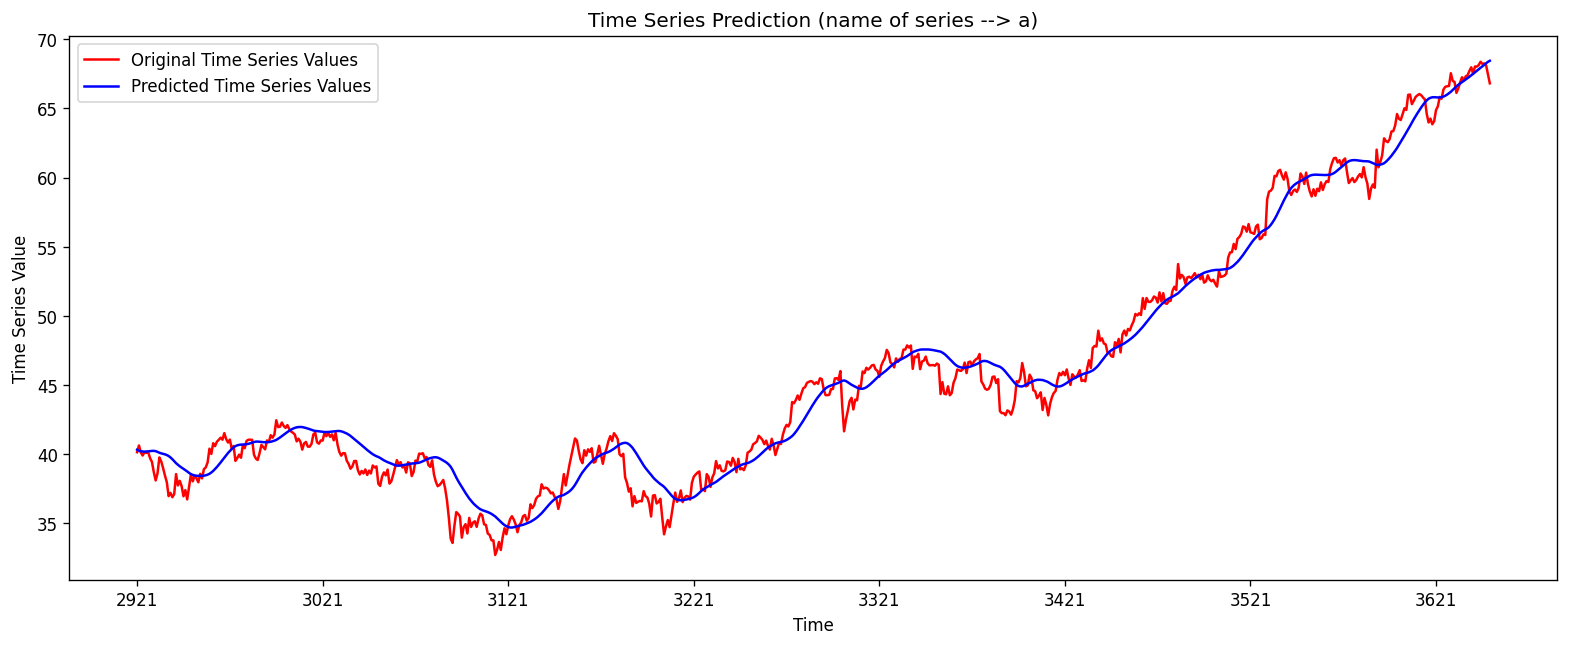

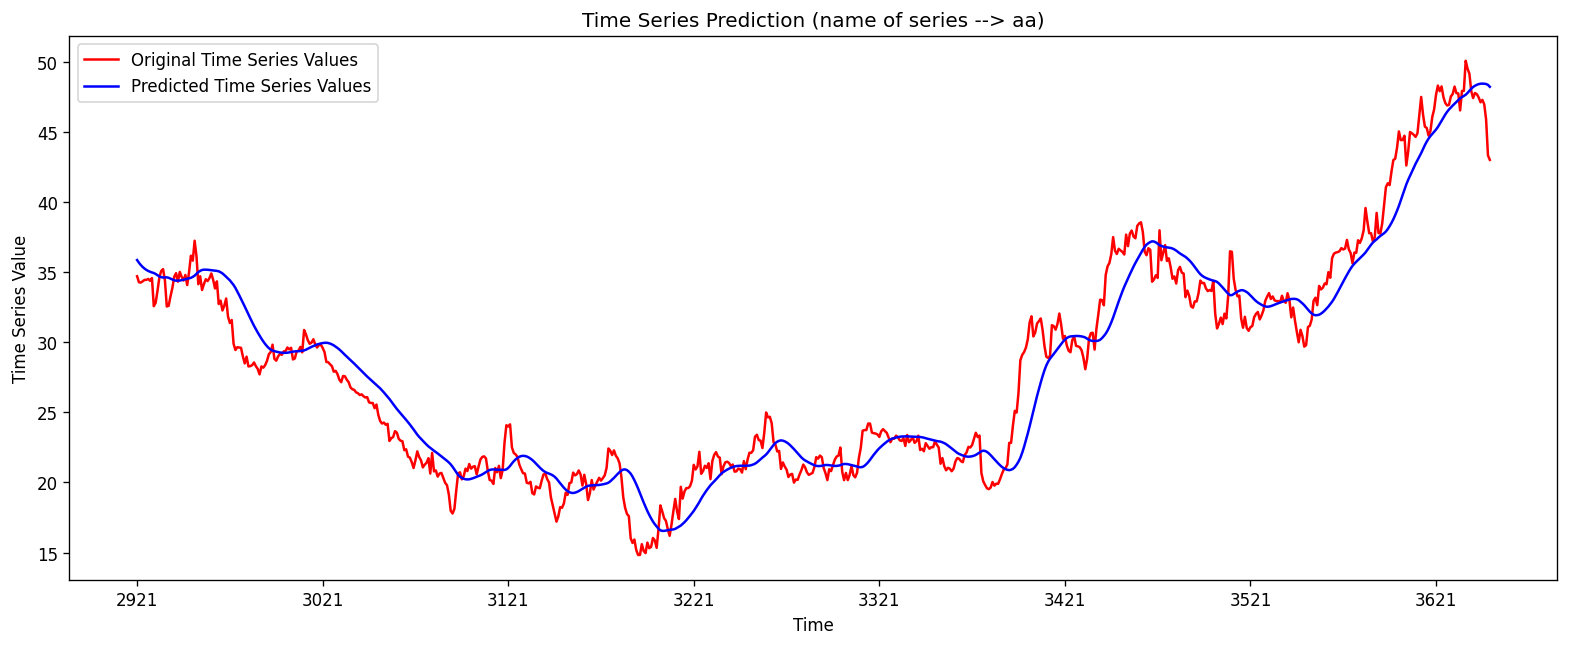

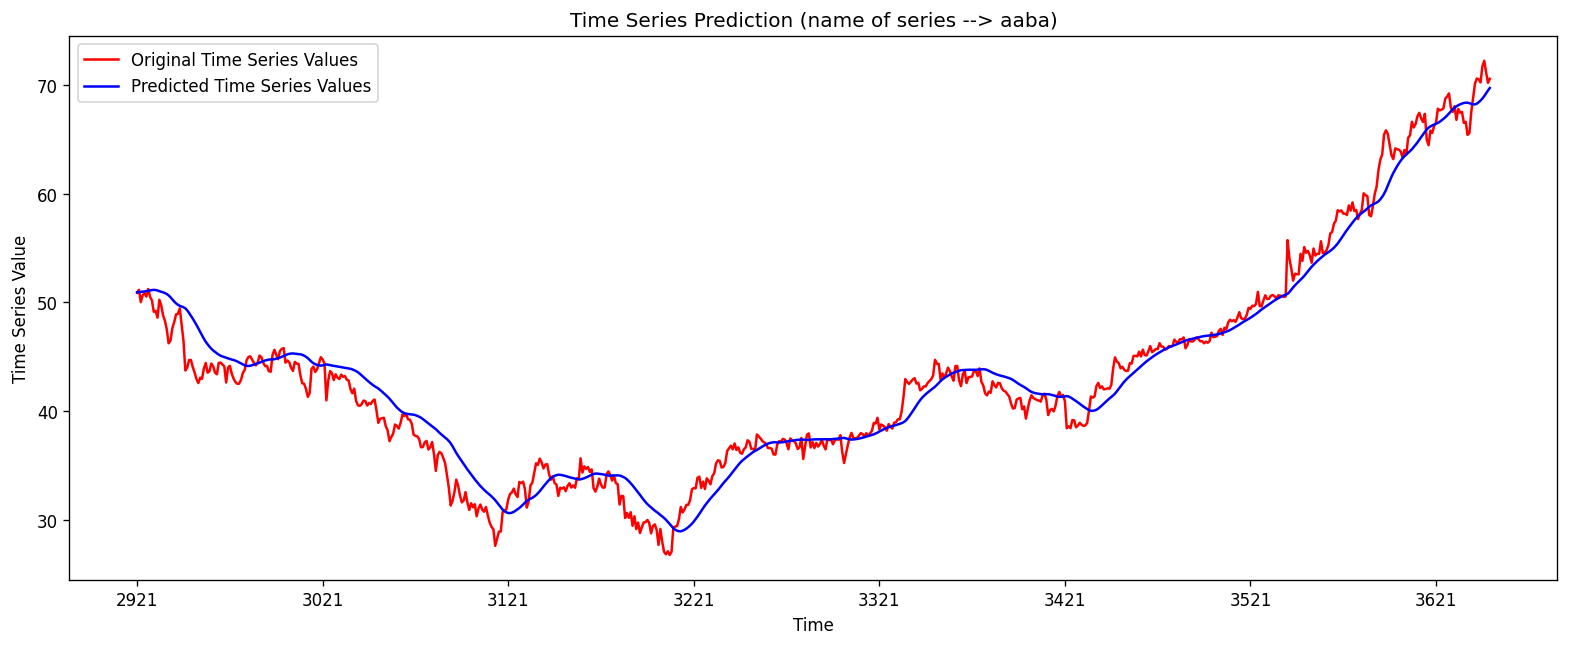

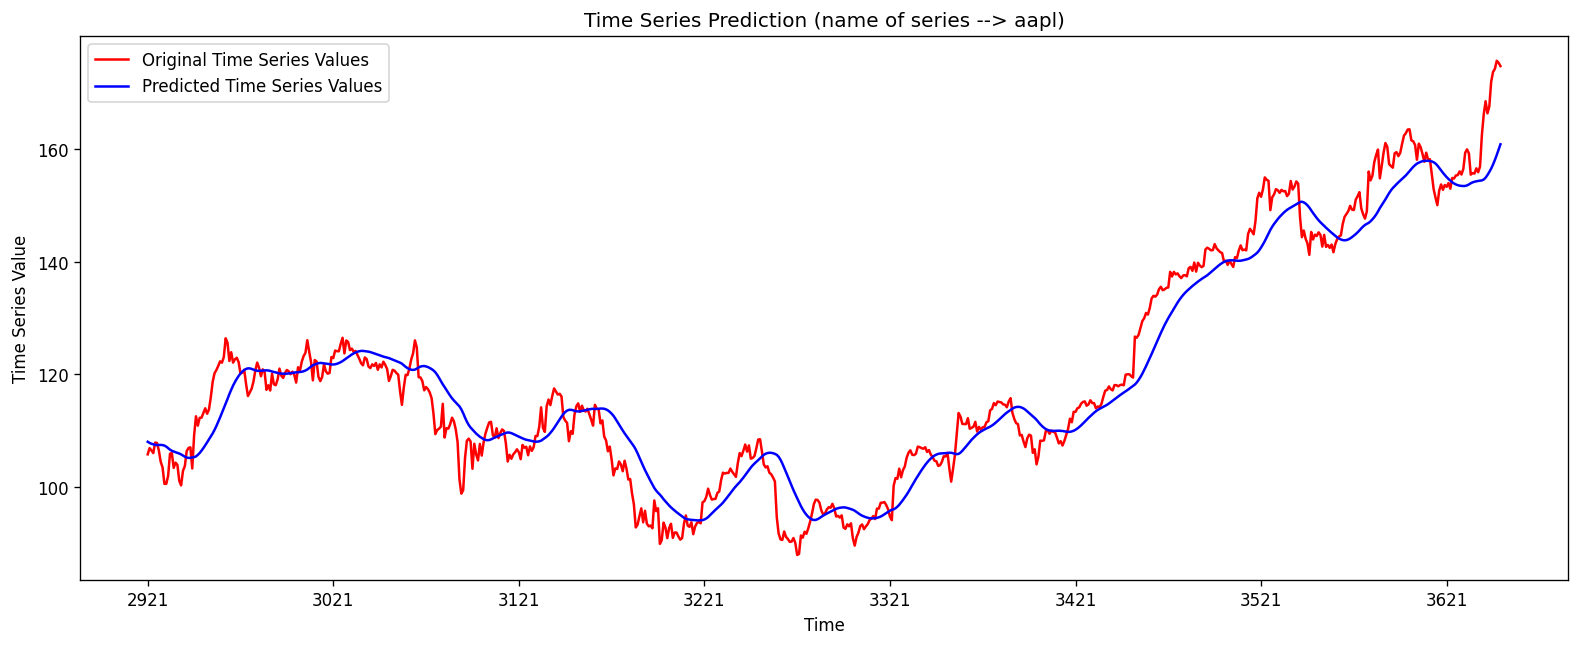

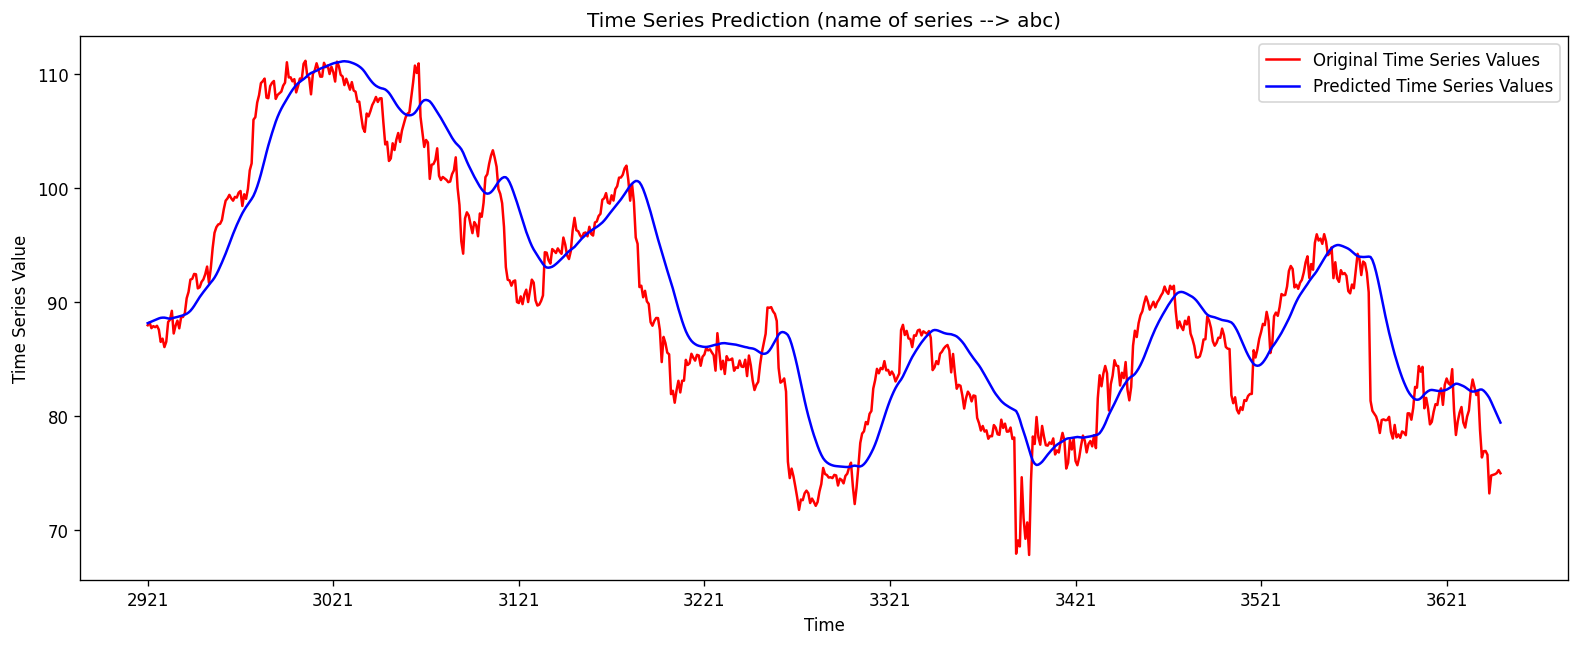

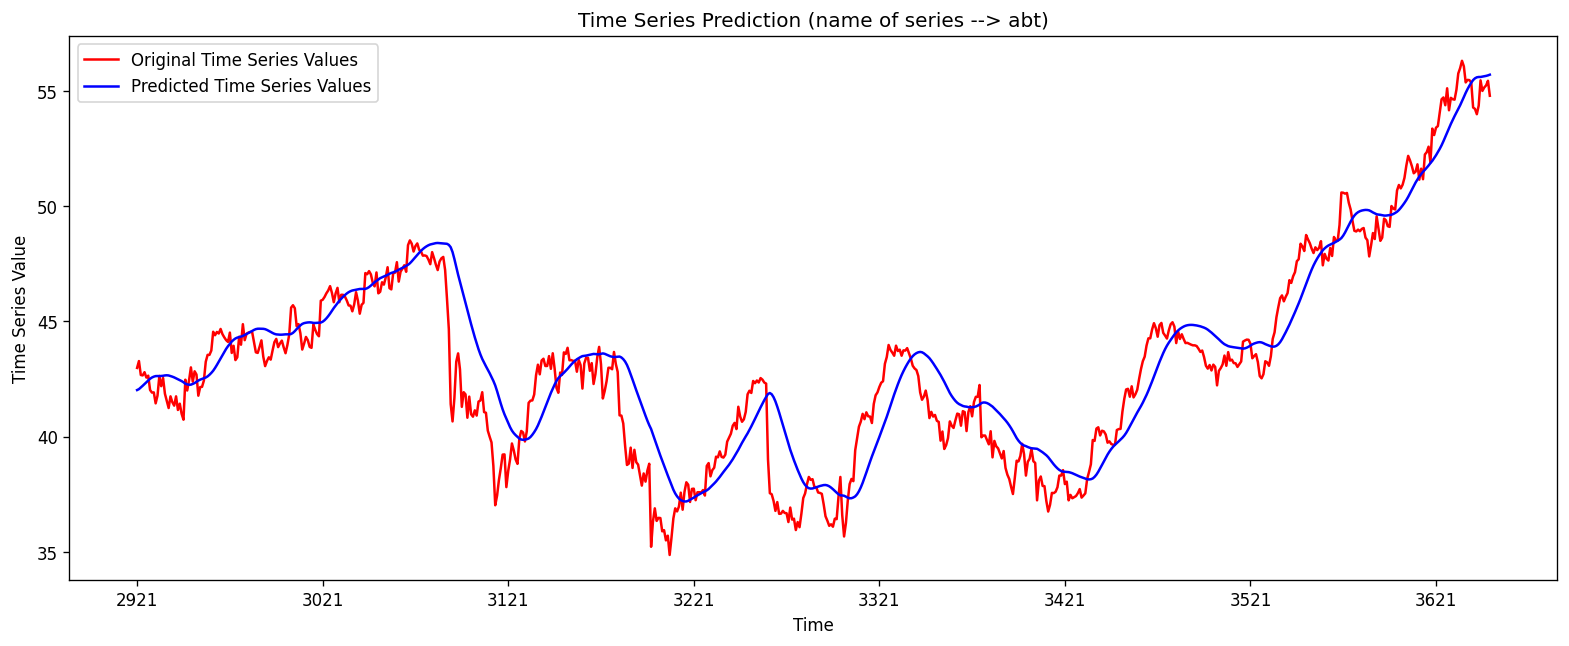

<Figure size 432x288 with 0 Axes>

In [3]:
%run "/content/forecast.py" -d ./content/data/nasdaq2007_17.csv -n 6

## forecast_utils.py

In [1]:
""" file : forecast_utils.py """
""" helper functions for forecast.py main"""

""" general imports """
import sys
import string

""" imports for plots, dataframes, numpy """
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

""" keras neural network imports """
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping

""" sklearn imports """
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split


def config_model(input_size):
    """ configure and return RNN-LSTM model to be trained """
    model = Sequential()
    # Adding the first input LSTM layer
    model.add(LSTM(units = 100, return_sequences = True, input_shape = (input_size, 1)))
    # Dropout layer to avoid overfitting
    model.add(Dropout(0.3))
    # Adding a second LSTM layer
    model.add(LSTM(units = 100))
    # Dropout layer to avoid overfitting
    model.add(Dropout(0.3))
    # Adding the output layer
    model.add(Dense(units = 1))
    # Compiling the RNN by determinng optimizer and loss function
    model.compile(optimizer = 'sgd', loss = 'mean_squared_error')
    return model


def plot_loss(history):
    """ plot the train loss vs test loss learning curve for given training history """
    plt.figure(figsize=(16, 6), dpi=120)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model train vs test loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()


def plot_series(time_points, original_series, predicted_series, window, series_name):
    """ plot the original time series vs predicted time series """
    plt.figure(figsize=(16, 6), dpi=120)
    plt.plot(time_points, original_series, color = 'red', label = 'Original Time Series Values')
    plt.plot(time_points, predicted_series, color = 'blue', label = 'Predicted Time Series Values')
    plt.xticks(np.arange(time_points[0], time_points[-1], window))
    plt.title("Time Series Prediction (name of series --> %s)" % (series_name))
    plt.xlabel('Time')
    plt.ylabel('Time Series Value')
    plt.legend()
    plt.show()

def create_dataset(input_set, num_of_series, num_of_steps, w):
    """ creates the x_set, y_set (x_train / y_train or x_test / y_test ) out of the input_set
        input_set : 2D array -> columns are different time series, rows are time series values across time
        num_of_series : number of series in input_set
        num_of_steps  : number of steps = size of x_set and y_set
        w : window of sampling """

    # x_set will contain windows of w consecutive values for all time series of input_set
    x_set = []
    # y_set will contain the next value of corresponding time series for each of the windows of x_set
    y_set = []

    for series_index in range(num_of_series):
        for i in range(w, num_of_steps + w):
            # append next window of w consecutive values of time series in x_set
            x_set.append(input_set[i-w:i, series_index])
            # append next value of time series outside current window in y_set
            y_set.append(input_set[i, series_index])

    # convert to np arrays
    x_set, y_set = np.array(x_set), np.array(y_set)
    # reshape x_set to a tensor of size (#time_series * num_of_steps, window, 1)
    x_set = np.reshape(x_set, (x_set.shape[0], x_set.shape[1], 1))

    return x_set, y_set


def execute(series_values, series_names, w, n, load_trained_model, series_to_use):
    """ function where main work gets done
        series_values : 2D array -> columns are different time series, rows are time series values across time
        series_names  : 1D array -> rows have the names of the time series
        w : window of sampling
        n : number of series to make predictions for
        load_trained_model : if True, a pre trained model will be loaded, otherwise a new model will be trained
        series_to_use   : if not None, training/loading is done per given series, otherwise per entire set of series """

    # train test split 80-20 rule (the first 80% of time series values will be used for the training, rest 20% for testing)
    train_set_size = math.floor((series_values.shape[0])*0.8)

    # save train set after split
    train_set = series_values[:train_set_size]

    # save test set after split
    test_set = series_values[train_set_size:]

    # scale train set manually using min max scaling
    scaled_train_set = (train_set - train_set.min()) / (train_set.max() - train_set.min())

    num_of_series = series_values.shape[1]

    # get x_train, y_train
    x_train, y_train = create_dataset(scaled_train_set, num_of_series, train_set.shape[0] - w, w)

    if load_trained_model is False:
        # configure new RNN-LSTM model
        model = config_model(x_train.shape[1])
    else:
        if series_to_use is not None:
            # load pre trained RNN-LSTM model for series
            model = load_model('./content/models/forecast/model_' + str(series_to_use) + '.h5')
        else:
            # load pre trained RNN-LSTM model for entire set of series
            model = load_model('./content/models/forecast/big_model.h5')

    # getting all the values of all selected time series starting from the last window before the test set
    inputs = series_values[series_values.shape[0] - test_set.shape[0] - w:]
    # normalize with minmax normalization based on train set
    inputs = (inputs - train_set.min()) / (train_set.max() - train_set.min())

    # get x_test, y_test
    x_test, y_test = create_dataset(inputs, num_of_series, test_set.shape[0], w)

    # if load_trained_model option was not given, train new model
    if load_trained_model is False:
        # train model by fitting it to the training set
        history = model.fit(x_train, y_train, epochs = 60, batch_size = 256, validation_data=(x_test, y_test), verbose=1)
        # plot the train loss vs test loss learning curve for given training history
        plot_loss(history)

        if series_to_use is not None:
            # save trained RNN-LSTM model of series, for future use
            model.save('./content/models/forecast/model_' + str(series_to_use) + '.h5')
        else:
            # save trained RNN-LSTM model of entire set of series, for future use
            model.save('./content/models/forecast/big_model.h5')

    # time axis
    time_points = [index + 1 for index in range(train_set.shape[0], series_values.shape[0])]

    # for each of the selected time series make the original vs predicted series plot
    for series_index in range(n):
        # get name for current time series
        series_name = series_names[series_index, 0]

        # get original series (test set) for current time series
        original_series = test_set[:, series_index:series_index+1]

        # get x_test for current time series
        x_test_series = x_test[test_set.shape[0] * series_index : test_set.shape[0] * (series_index+1), :, :]

        # get predictions of future time series values (time series values on test set) (for current time series)
        predicted_series = model.predict(x_test_series)

        # get unscaled predictions of time series values (manual inverse transform)
        predicted_series = predicted_series * (train_set.max() - train_set.min()) + train_set.min()

        # plot the original time series vs predicted time series
        plot_series(time_points, original_series, predicted_series, w, series_name)


## forecast.py

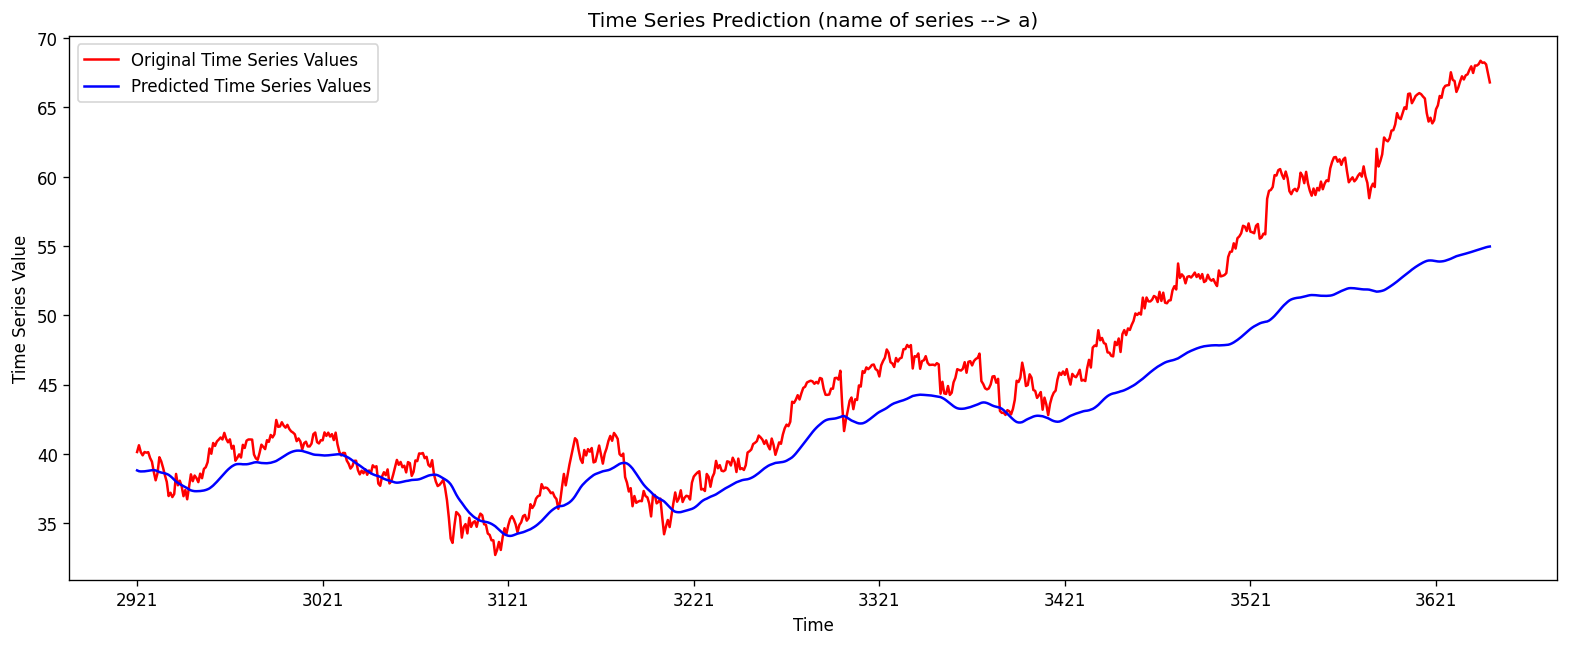

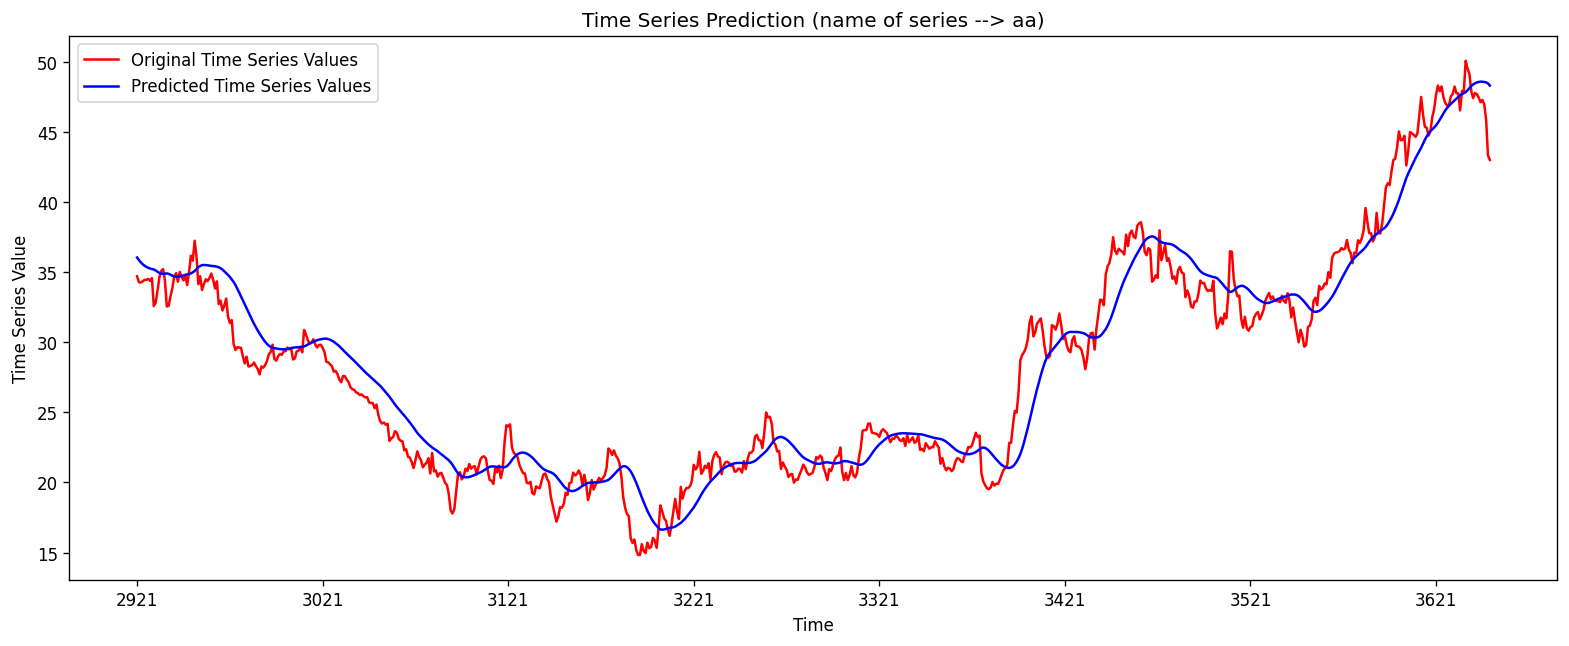

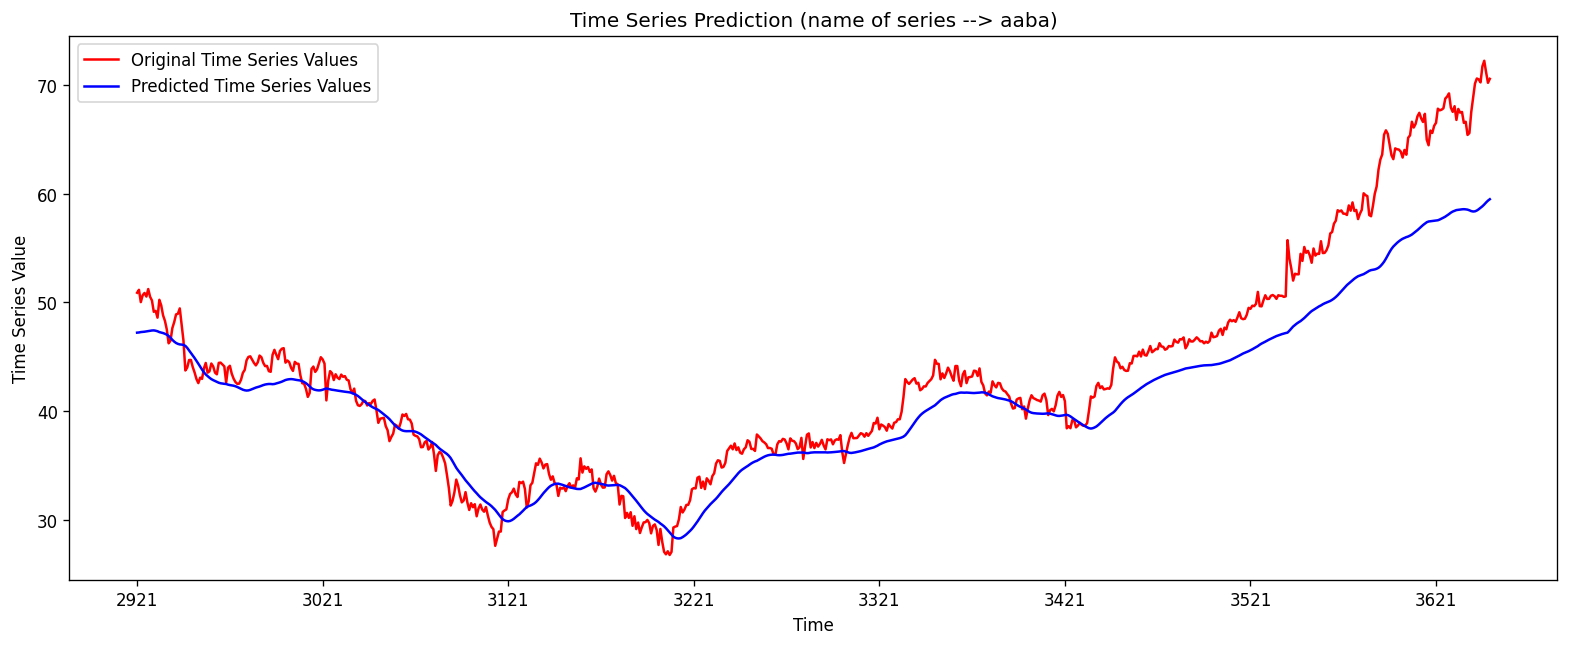

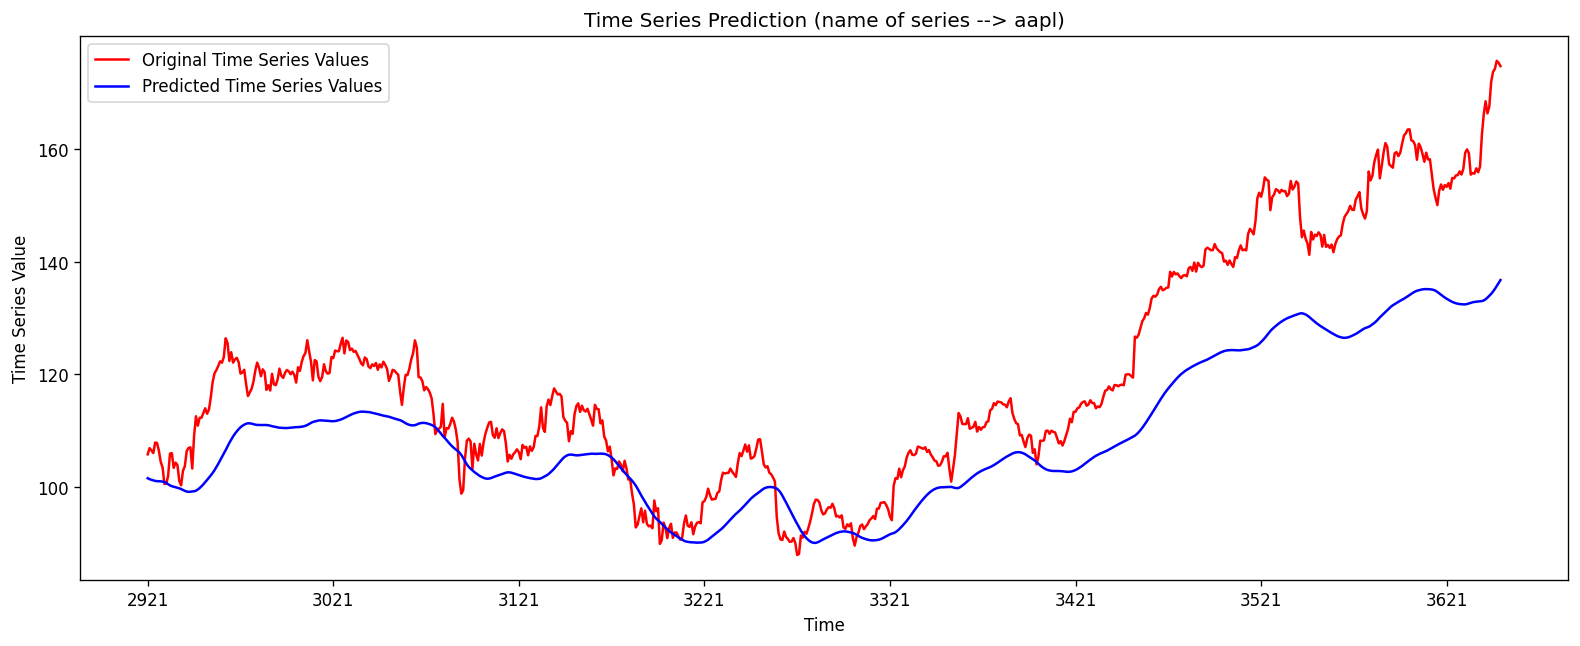

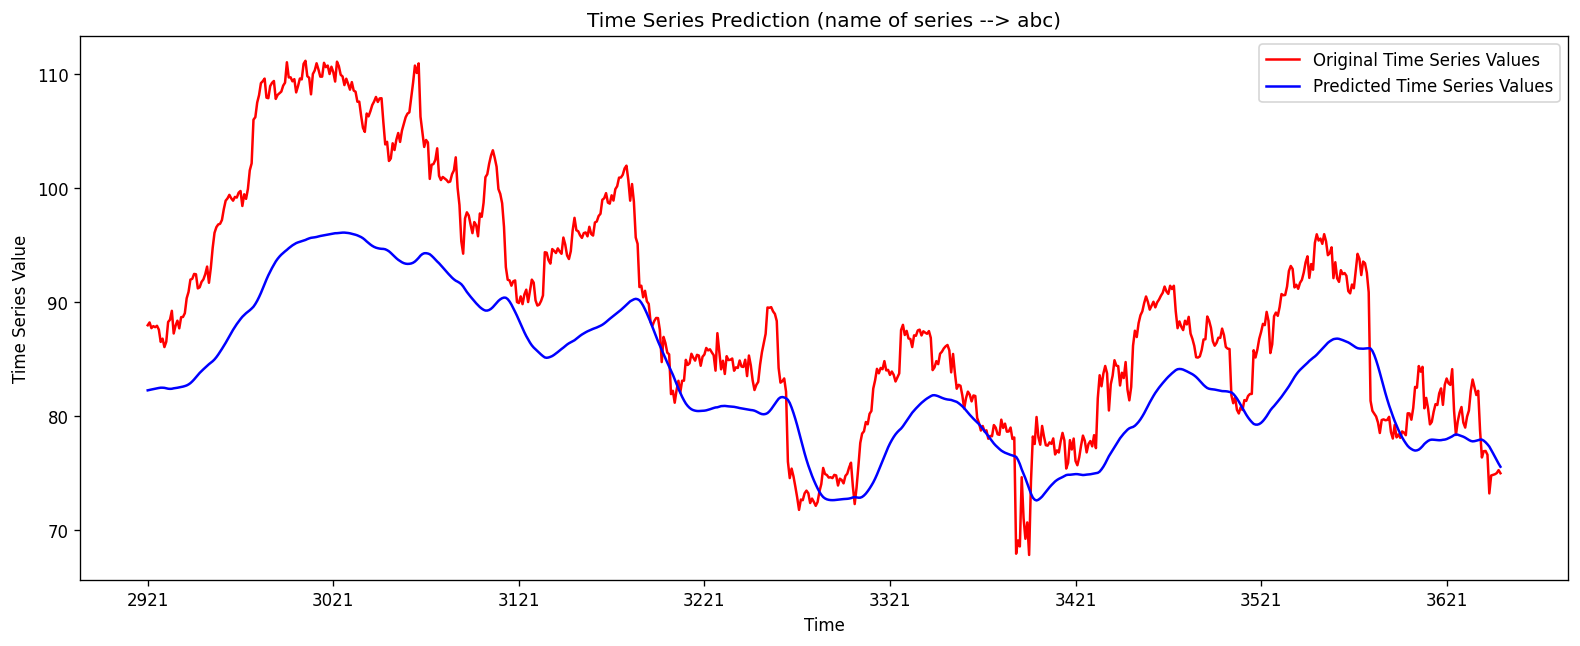

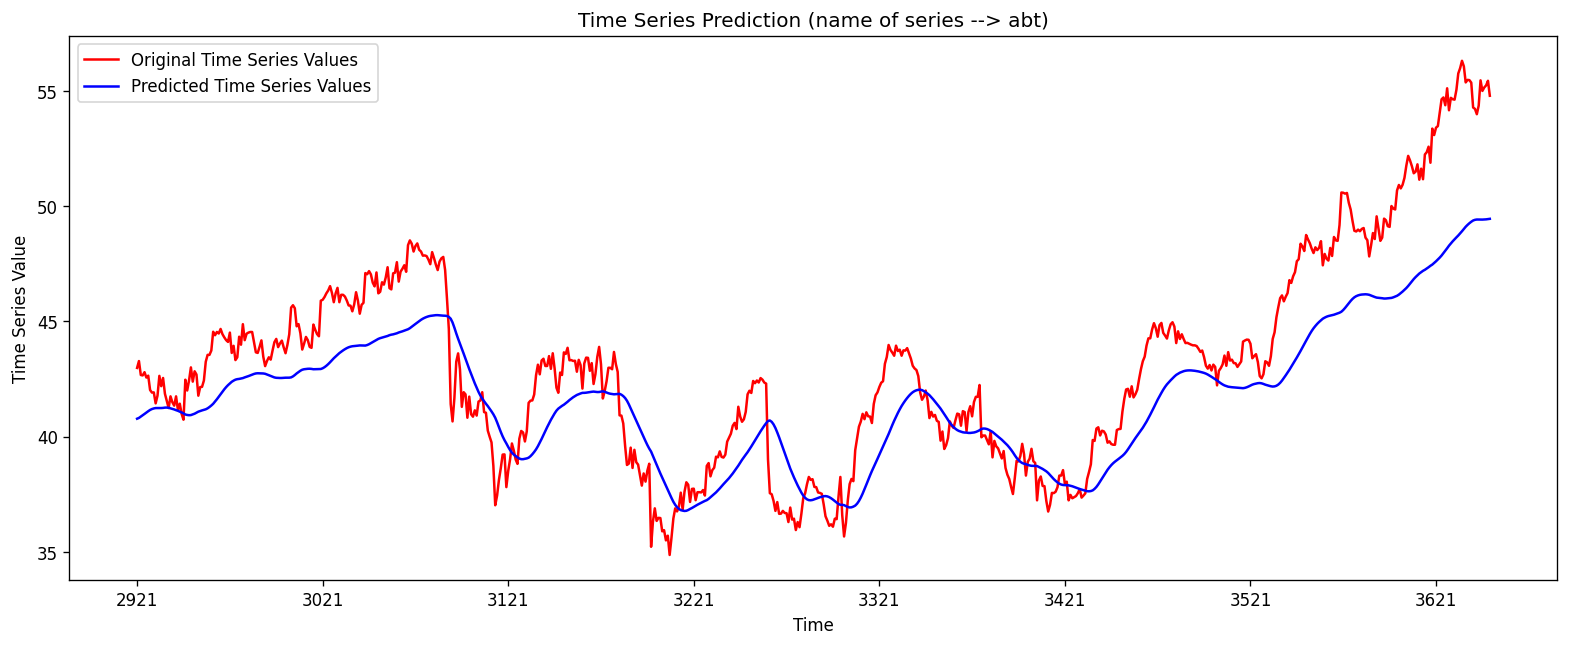

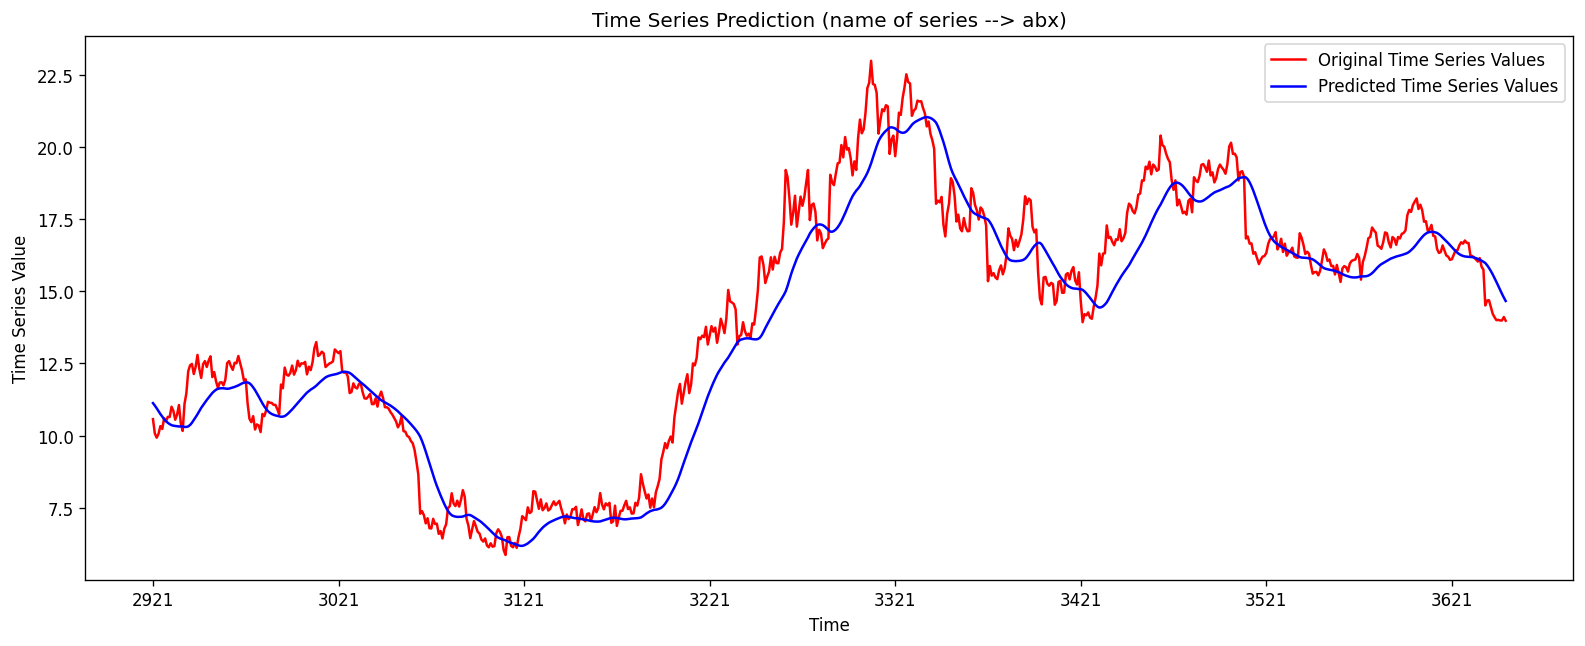

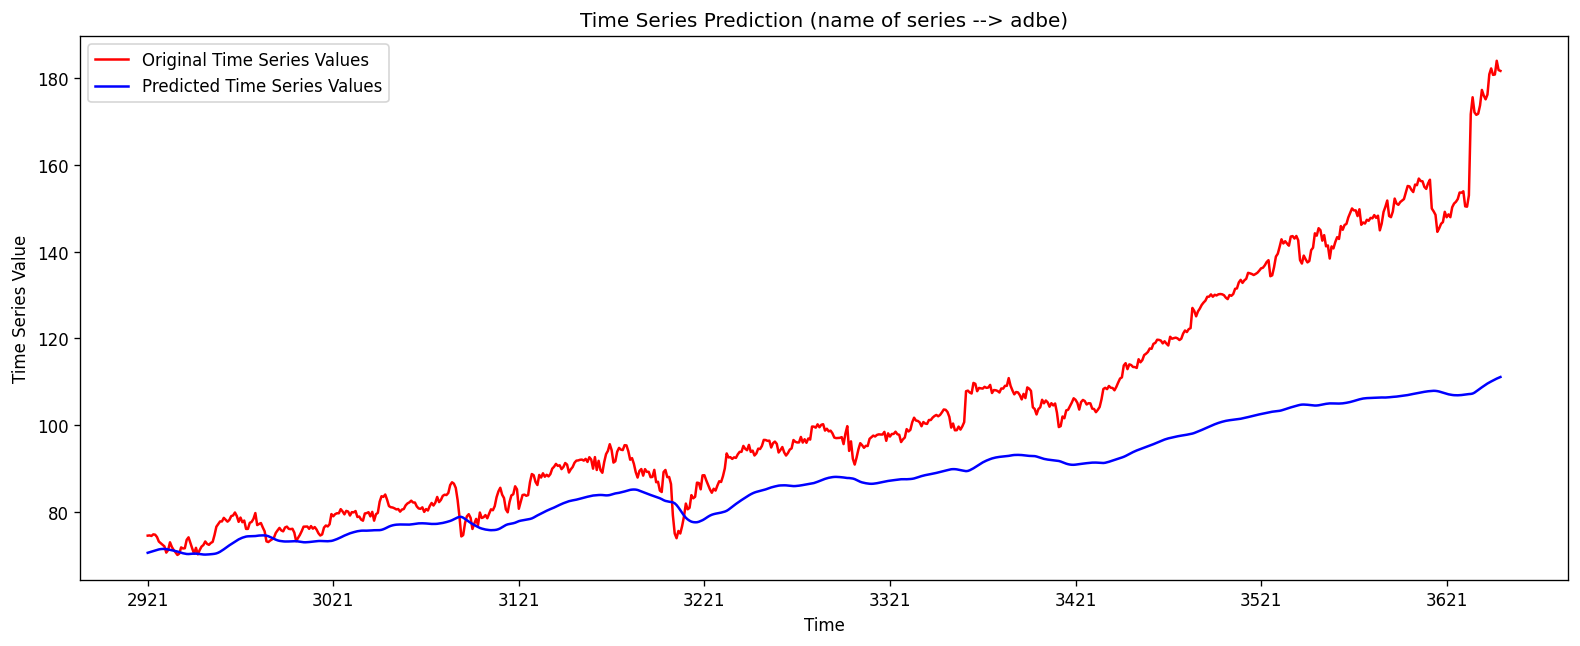

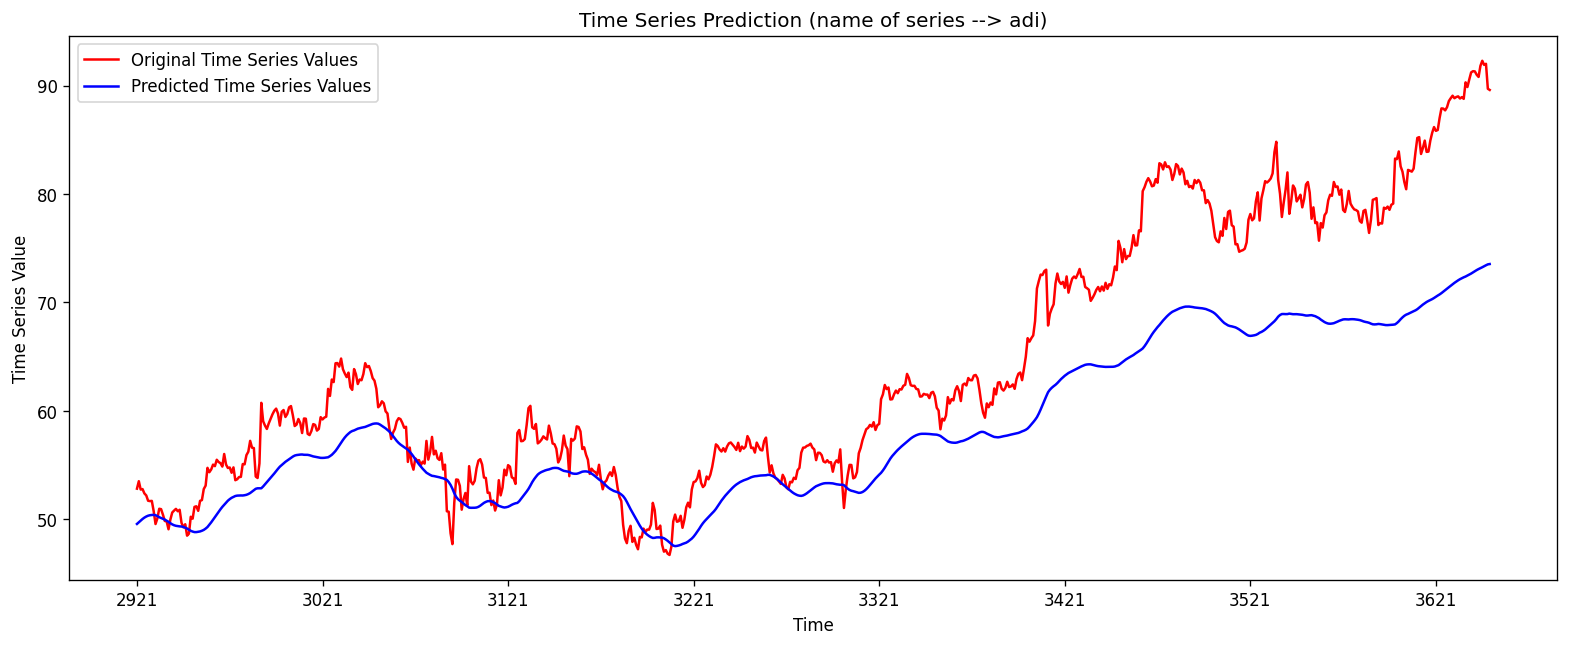

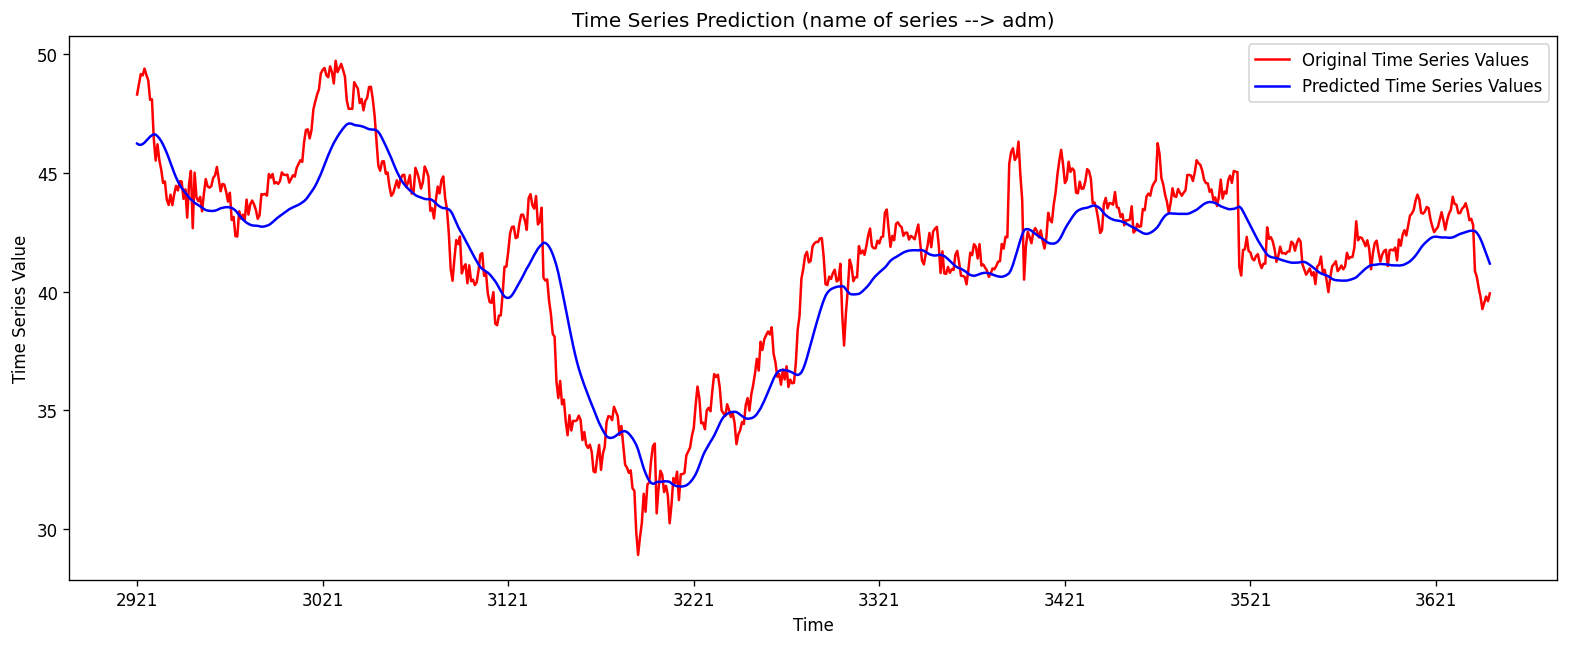

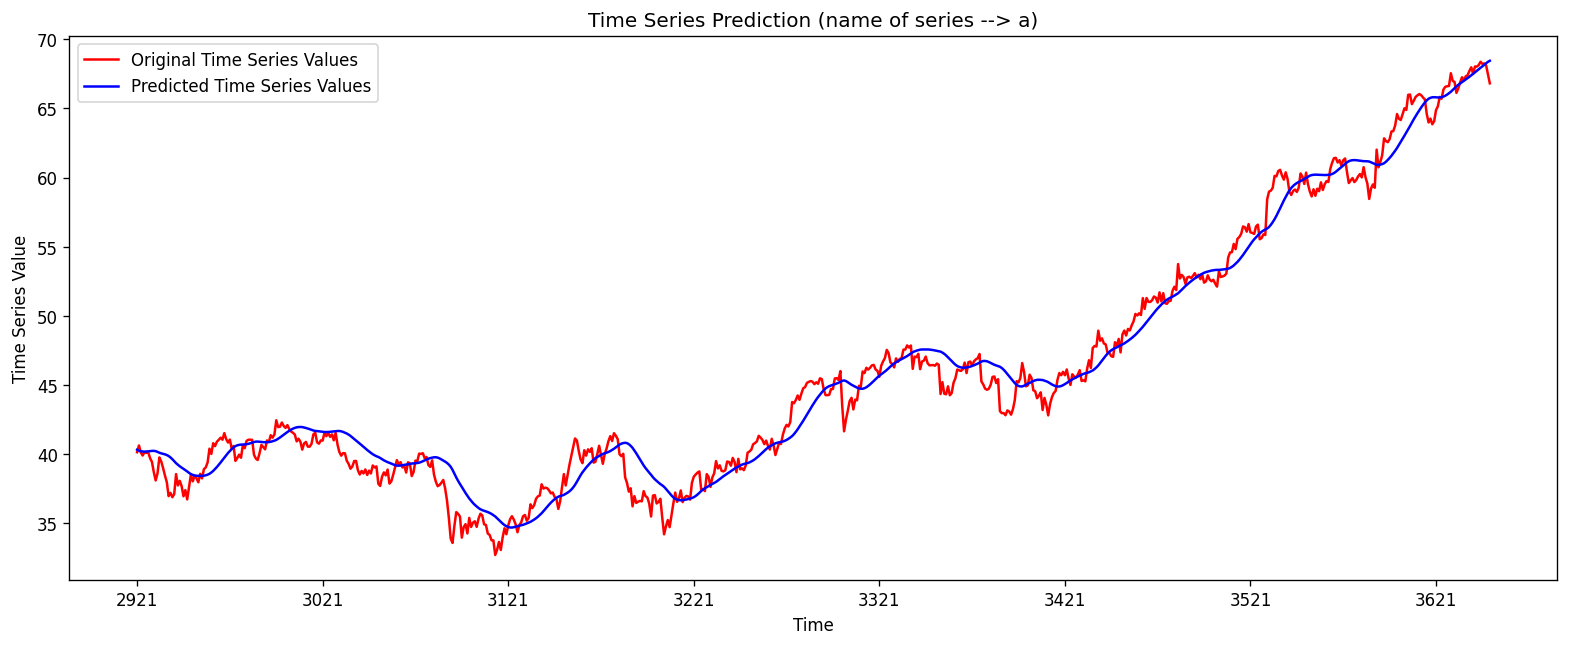

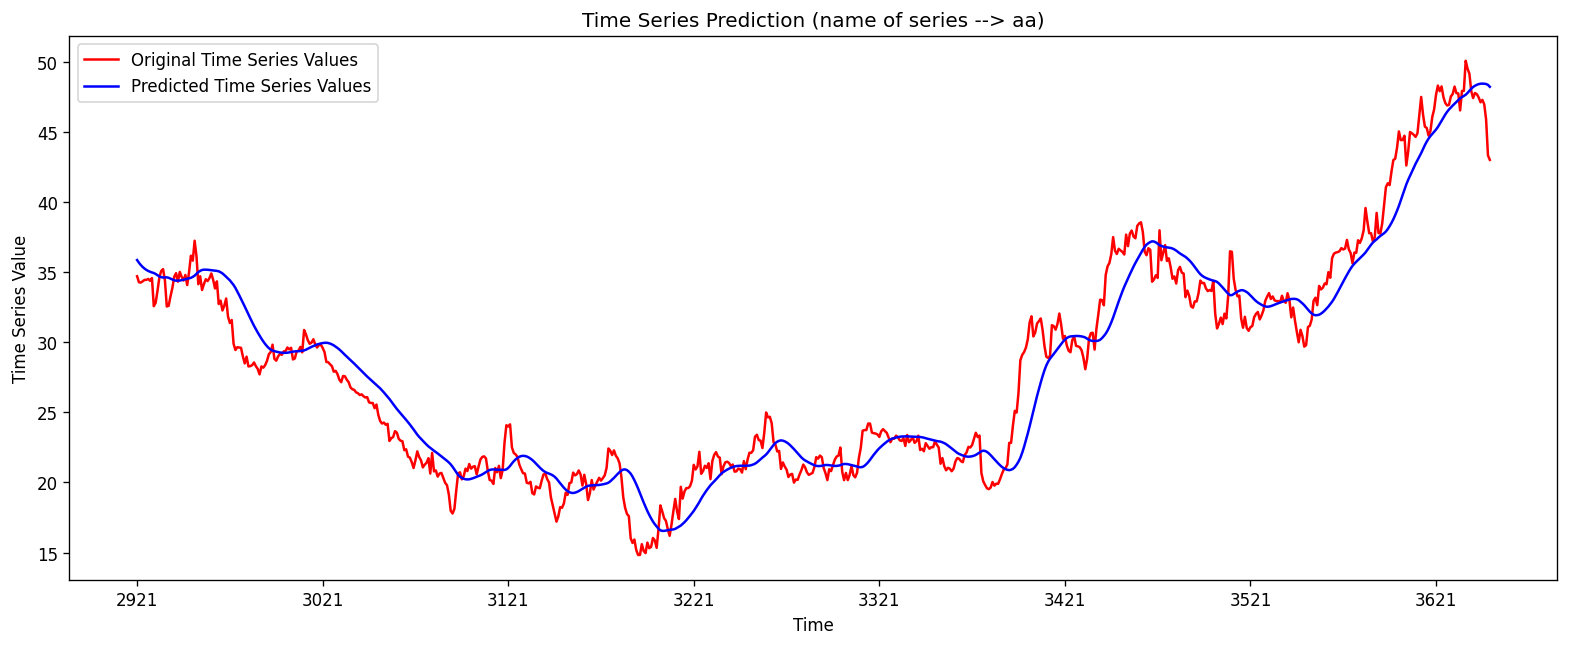

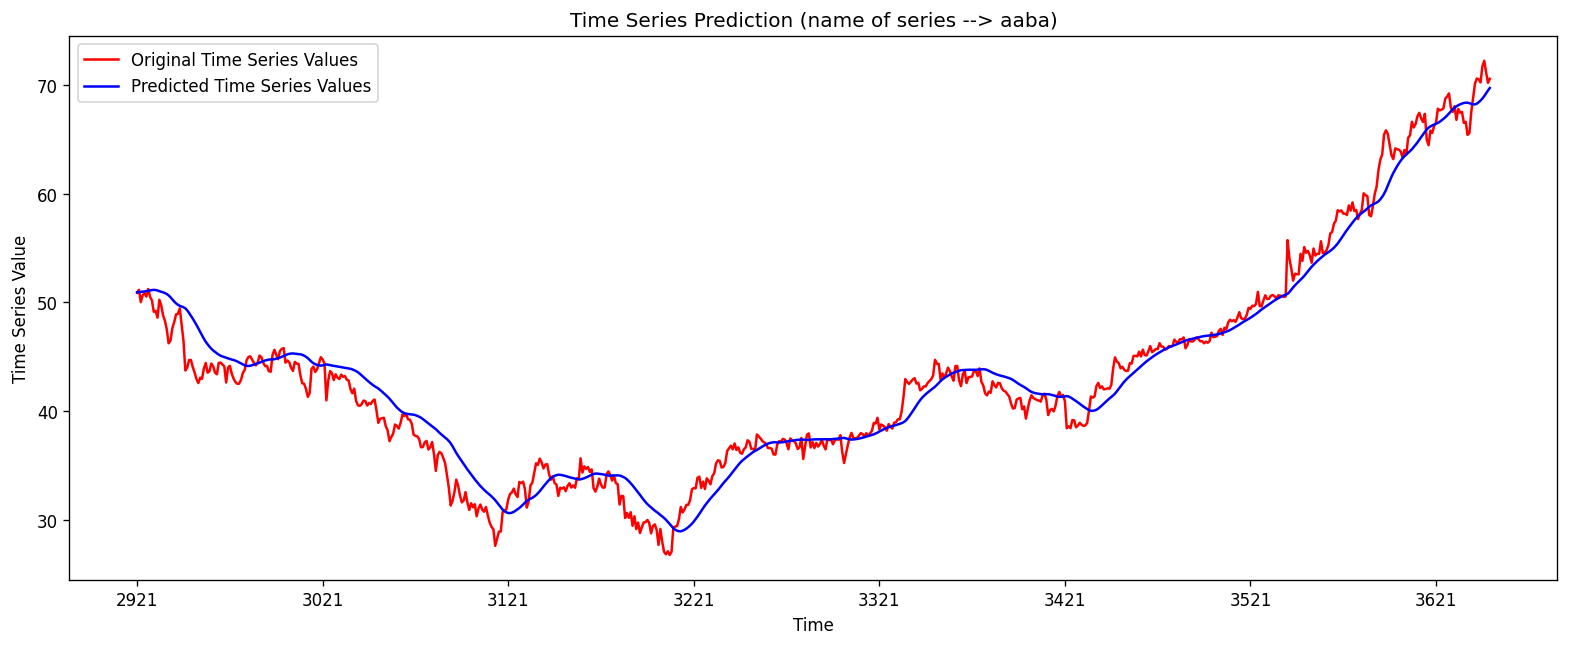

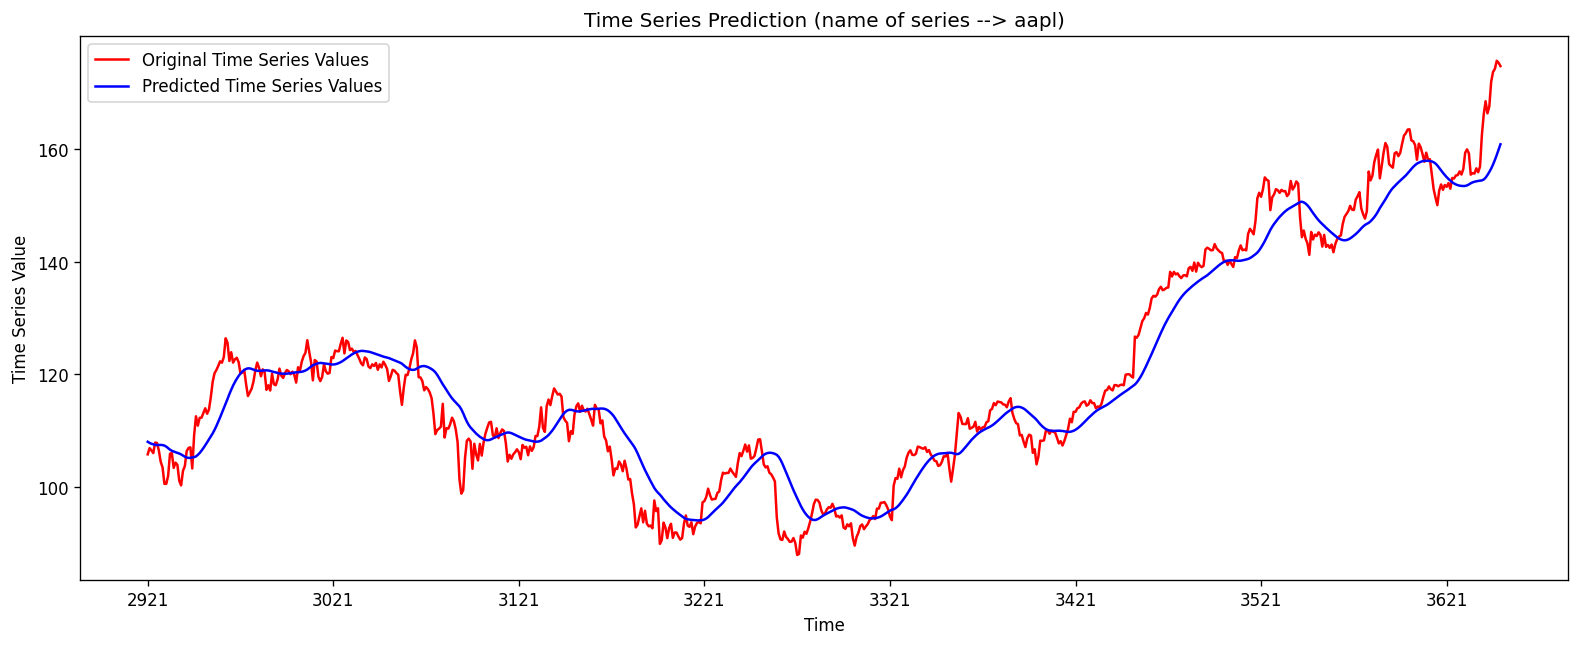

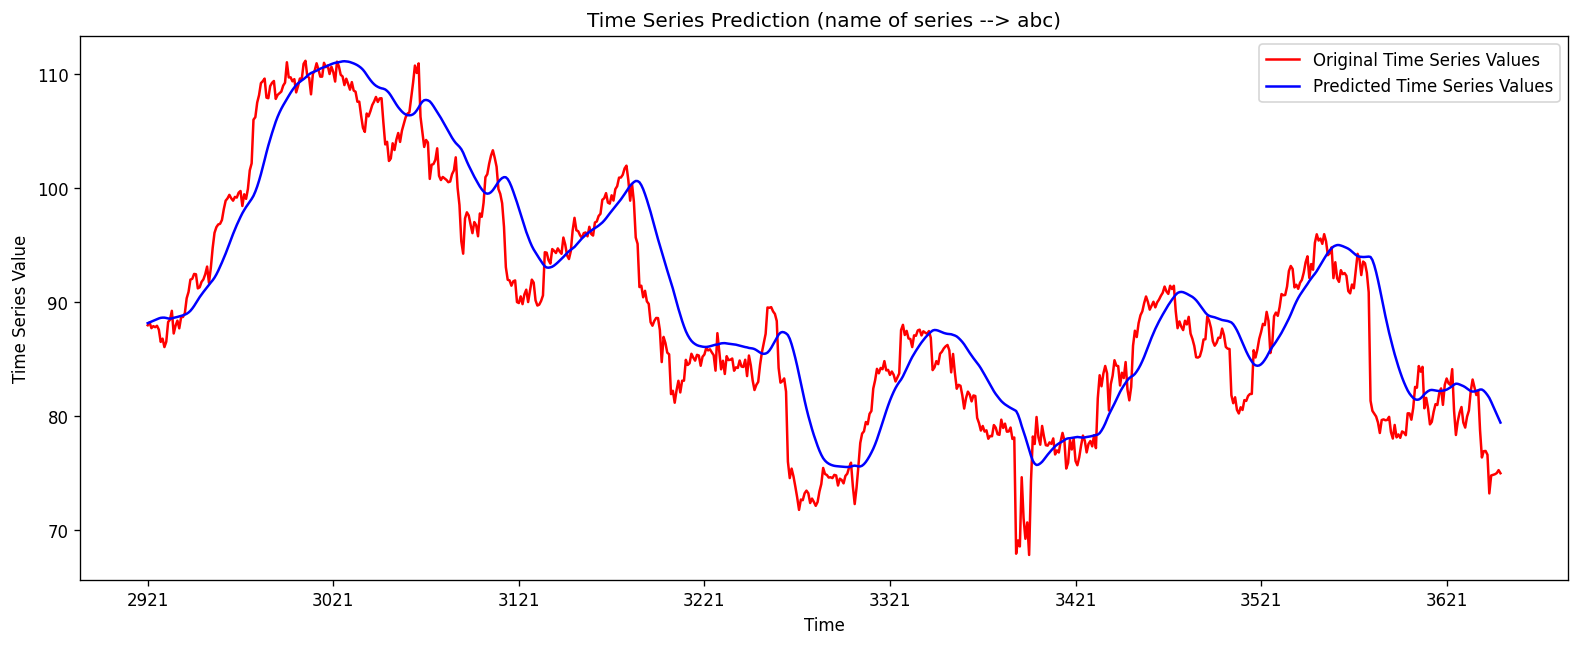

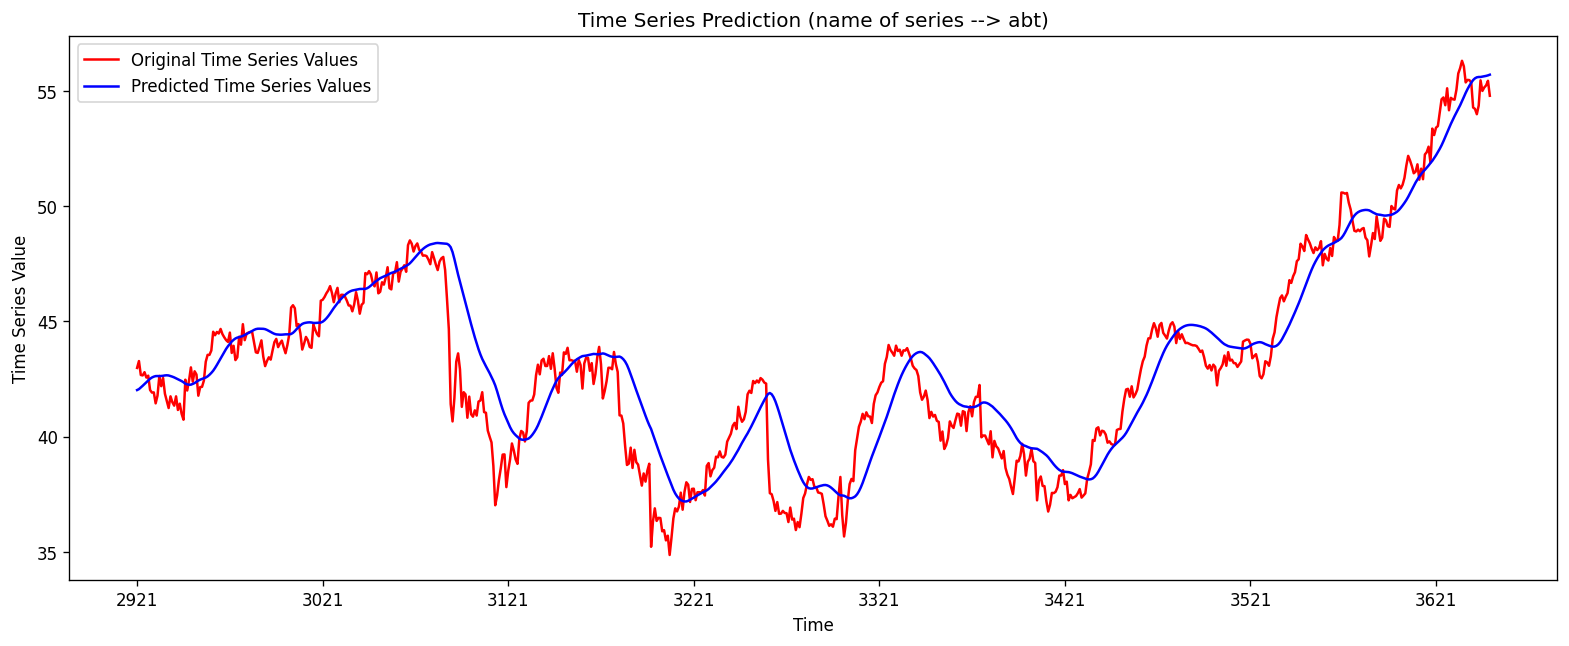

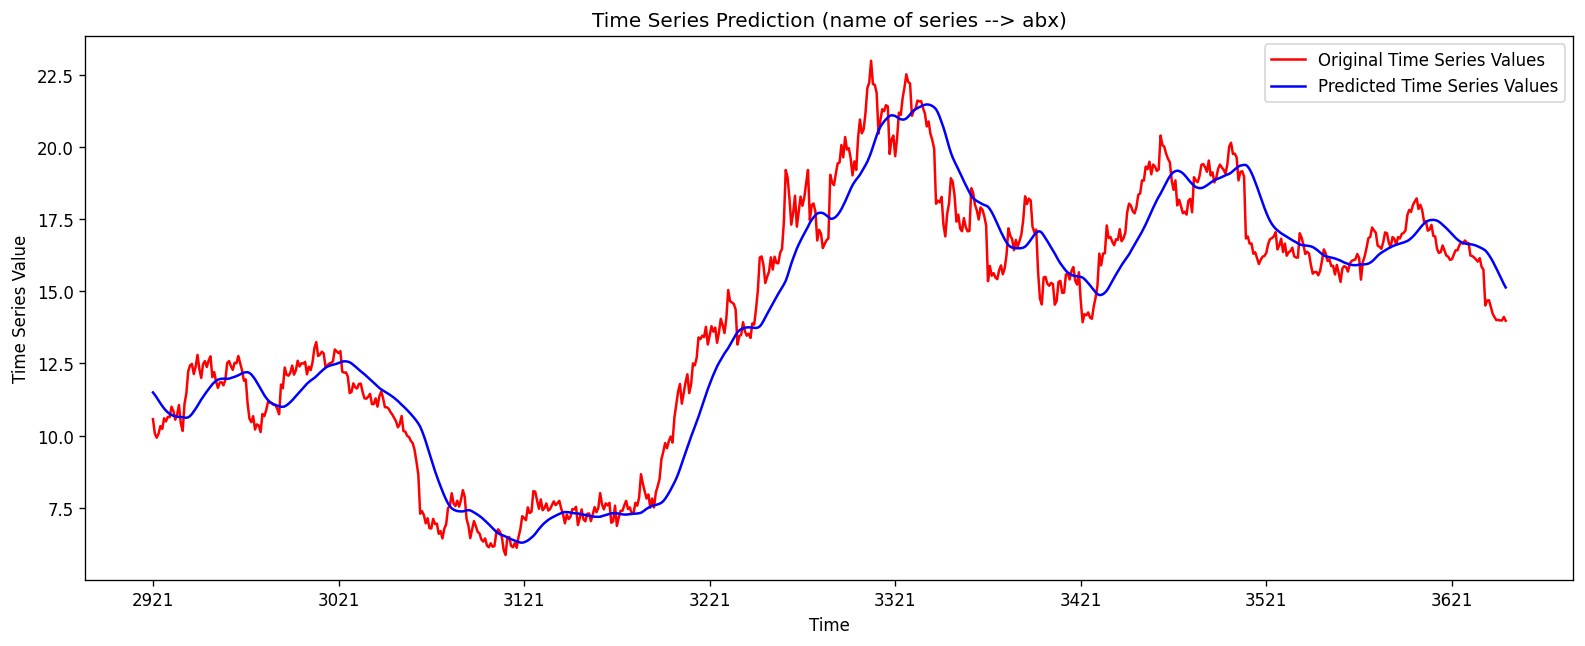

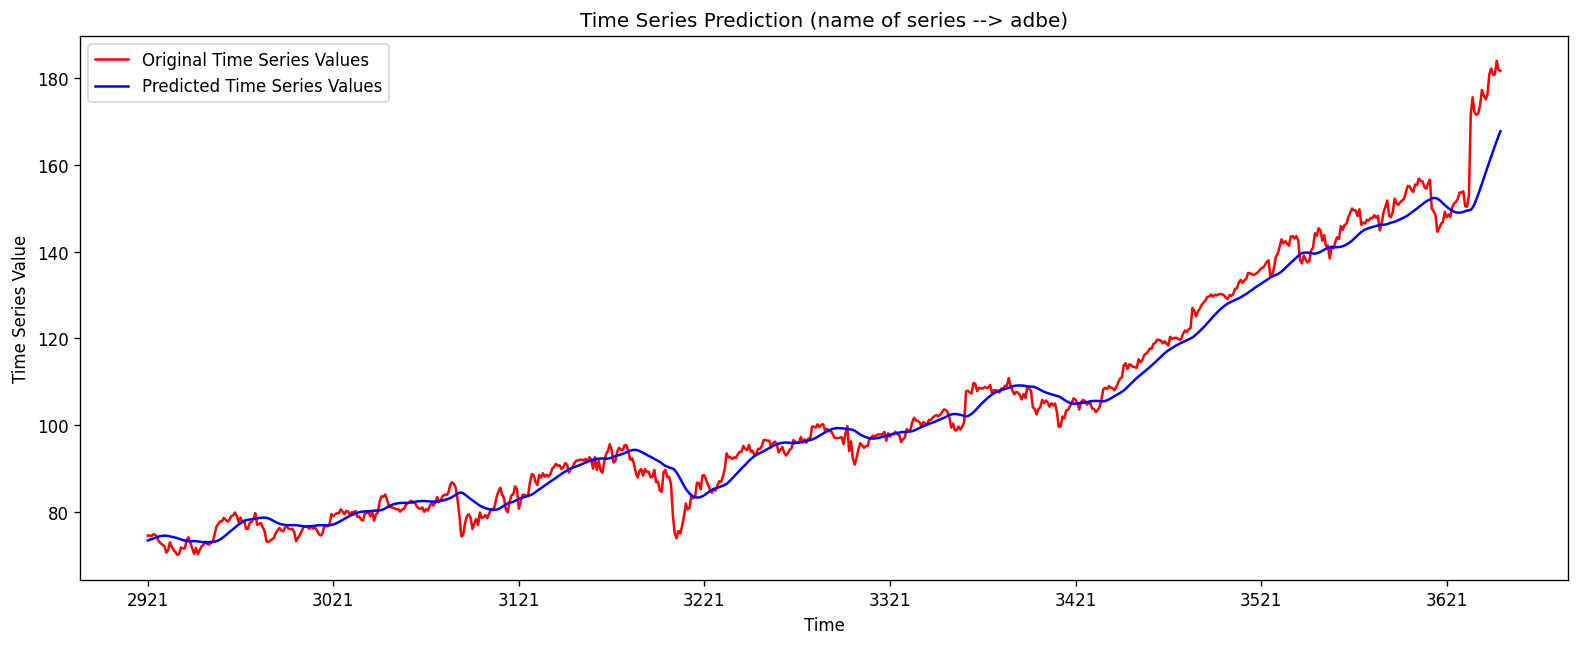

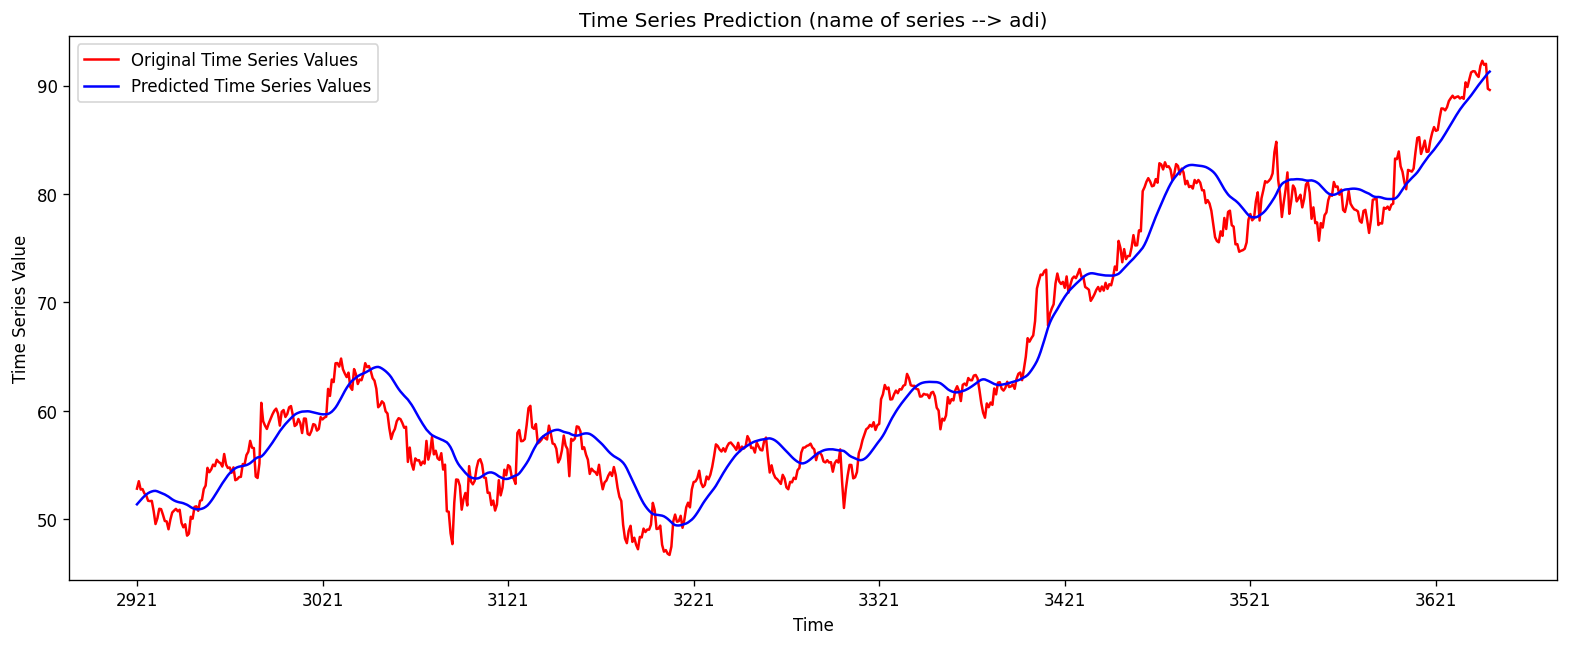

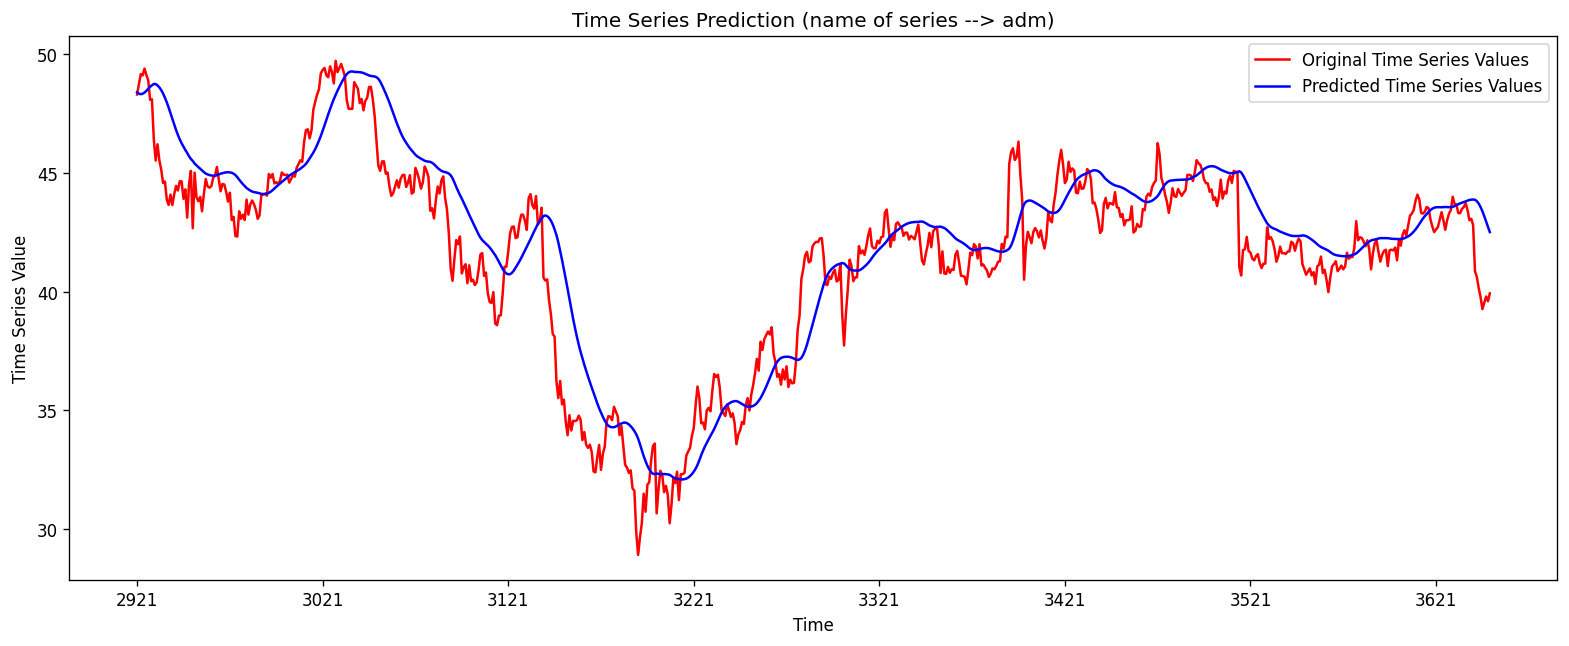

In [4]:
""" file : forecast.py """

""" general imports """
#import argparse     # for command line argument parsing
#import sys
#import string

""" imports for dataframes, numpy """
#import pandas as pd
#import numpy as np
#import math

""" import functions from forecast_utils.py """
#from forecast_utils import execute

# main functionality

# parse command line input
#parser = argparse.ArgumentParser()
#parser.add_argument('-d', help="Specify input dataset file path", type=str, required=True)
#parser.add_argument('-n', help="Specify index of time series to forecast", type=int, required=True)
#parser.add_argument('-load', help="Specify use of pre-trained models", dest='load', action='store_true', required=False)
#parser.add_argument('-train', help="Specify training of models", dest='load', action='store_false', required=False)
#parser.add_argument('-m', help="Specify capacity of model to be loaded", type=int, required=False)
#parser.set_defaults(load=True)
#parser.set_defaults(m=20)
#args = parser.parse_args()

#if args.n < 1:
#    sys.exit("Invalid time series index. Index should be positive integer\n")

# save arguments
dataset_path = './content/data/nasdaq2007_17.csv'
num_of_series = 10

# load pre trained model or train new model
load_trained_model = True
# capacity of model to be loaded
model_size = 20

# Load and peek the input dataset csv file
dataset = pd.read_csv(dataset_path, sep='\t', lineterminator='\n', header=None)

# keep names of time series in seperate dataframe and convert it to an array
series_names = pd.DataFrame(dataset, columns=[dataset.columns[0]]).values

# specify columns to keep (all but the first one)
cols = [False]
rest_cols= [True for x in range(dataset.shape[1]-1)]
cols.extend(rest_cols)

# set window
w = 100

# train one model for/over each of the series
for series_index in range(num_of_series):
    # keep series name
    series_name = series_names[series_index, 0]

    # convert input dataset for specific time series to array of series values
    series_values = dataset.iloc[[series_index], cols].values

    # reshape to column array.  Rows are time series values at specific time points
    series_values = series_values.reshape(-1,1)

    # execute training, plots
    execute(series_values, series_names[series_index:], w, 1, load_trained_model, series_index)


# train one model over all series

# convert input dataset for first n time series to array of series values
if load_trained_model is False:
    # train one model over all series
    series_values = dataset.iloc[:num_of_series, cols].values
else:
    # restrict dataset to model's capacity
    series_values = dataset.iloc[:model_size, cols].values

# get transpose to have columns as different time series and rows as time series values at specific time points
series_values = series_values.T

# execute training, plots
execute(series_values, series_names, w, num_of_series, load_trained_model, None)
